<br>
<h1 style = "font-size:40px; font-family:Garamond ; font-weight : normal; background-color: black ; color : #CCCC00; text-align: center; border-radius: 100px 100px;padding:10px">Object Detetction with YOLO </h1>
<br>

<img src="https://pjreddie.com/media/image/yologo_2.png">
<span style="font-size:15px">
You only look once (YOLO) is a state-of-the-art, real-time object detection system. On a Pascal Titan X it processes images at 30 FPS and has a mAP of 57.9% on COCO test-dev.
</span><br>
<hr style="border:2px solid gray">
<!-- <b><span class="label label-default" style="color:#03e8fc;font-size:30px;border-radius:6px;"> Performance of YOLO with other Detectors</span></b><br> -->

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Performance of YOLO with other Detectors</span></h1>

<span style="font-size:15px">
YOLOv3 is extremely fast and accurate. In mAP measured at .5 IOU YOLOv3 is on par with Focal Loss but about 4x faster. Moreover, you can easily tradeoff between speed and accuracy simply by changing the size of the model, no retraining required!</span>
<br><br>
<span style="background-color:black">
<img src="https://pjreddie.com/media/image/map50blue.png" style="background-color: black">
</span><br>

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Working of YOLO</span></h1>
<br>
<span style="font-size:15px">
Prior detection systems repurpose classifiers or localizers to perform detection. They apply the model to an image at multiple locations and scales. High scoring regions of the image are considered detections.
YOLO uses a single neural network to the full image. This network divides the image into regions and predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.</span><br>

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">How is YOLO different from other detectors from R-CNN family</span></h1><br>
<span style="font-size:15px">
YOLO model has several advantages over classifier-based systems. It looks at the whole image at test time so its predictions are informed by global context in the image. It also makes predictions with a single network evaluation unlike systems like R-CNN which require thousands for a single image. This makes it extremely fast, more than 1000x faster than R-CNN and 100x faster than Fast R-CNN. See our paper for more details on the full system.</span>

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">How is YOLO different from other detectors from R-CNN family</span></h1><br>
<span style="font-size:15px">
In this notebook, we will discover :
<br><br>
1) How to develop a YOLOv3 model for object detection on new photographs.
After completing this tutorial, you will know:YOLO-based Convolutional Neural Network family of models for object detection and the most recent variation called YOLOv3.

2) The best-of-breed open source library implementation of the YOLOv3 for the Keras deep learning library.
How to use a pre-trained YOLOv3 to perform object localization and detection on new photographs.
</span>

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Object detection with Yolov3</span></h1><br>

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;">Create and Load pretrained model&nbsp;&nbsp;&nbsp;&nbsp;</h1> 
<span style="font-size:15px">
Steps:
1) These were trained using the DarkNet code base on the MSCOCO dataset. Download the model weights and place them into your current working directory with the filename “yolov3.weights.”

2) We need to define a Keras model that has the right number and type of layers to match the downloaded model weights. The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model.

3) We will create 2 helper function - one for loading the yolov3 pretrained weights and other for creating convolution blocks.

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Create block of layers</span></h1><br>

In [1]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
import glob

In [2]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Make YOLO model</span></h1><br>

In [3]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model
 

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Read and load the weight object</span></h1><br>

In [4]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,= struct.unpack('i', w_f.read(4))
            minor,= struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
            transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
 
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
 
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
 
    def reset(self):
        self.offset = 0

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Instantiate</span></h1><br>

In [5]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to output folder
model.save('model1.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
no convolution #12
loading weights of convolution #13
no convolution #13
loading weights of convolution #14
no convolution #14
no convolution #15
loading weights of convolution #16
no convolution #16
loading weights of convolution #17
no convolution #17
no convolution #18
loading weights of convolution #19
no convolution #19
loading weights of convolution #20
no convolution #20
no convolution #21
loading weights of convolution #22
no convolution #22
loading weights of convolution #23
no convolution #23
no convolution #24
loading weights of convolution #25
no convolution #25
loading weights of con

<h1 style="font-family: Verdana; font-size: 24px; font-style: normal; font-weight: bold; text-decoration: none; text-transform: none; letter-spacing: 3px; background-color: #ffffff; color: navy;">Prepare the input image for model prediction&nbsp;&nbsp;&nbsp;&nbsp;</h1> 

We need to load our new photograph and prepare it as suitable input to the model. The model expects inputs to be color images with the square shape of 416×416 pixels.

We can use the load_img() Keras function to load the image and the target_size argument to resize the image after loading. We can also use the img_to_array() function to convert the loaded PIL image object into a NumPy array, and then rescale the pixel values from 0-255 to 0-1 32-bit floating point values.

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Load the saved yolov3 model</span></h1><br>

In [6]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
 
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height
 
# load yolov3 model
model = load_model('model1.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Load the sample image</span></h1><br>

(380, 676, 3)


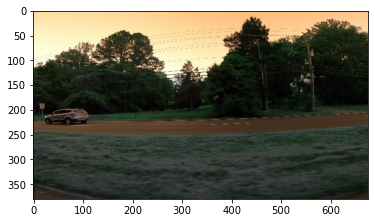

In [7]:
## load a image
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
img=cv2.imread('/home/zahid/Downloads/objectDetection ssd/data/training_images/vid_4_10000.jpg')
plt.imshow(img)
print(img.shape)

(380, 676, 3)


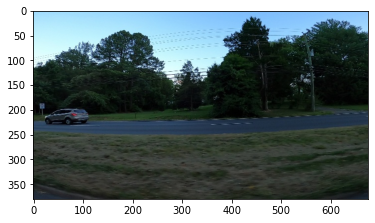

In [8]:
img_cvt=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img_cvt)
print(img_cvt.shape)

In [9]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
#     return float(intersect) / union
    return intersect / union

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [19]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename)
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape)
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
#     image = image.astype('float32')
    image /= 255.0
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
                # don't break, many labels may trigger for one box
    return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    # get the context for drawing boxes
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.2f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    # show the plot
    pyplot.show()

In [11]:
# load yolov3 model
model = load_model('model1.h5', compile=False)

In [12]:
# # load yolov3 model
# model = load_model('model1.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = '/home/zahid/Downloads/objectDetection ssd/data/training_images/vid_4_10000.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [13]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)

In [16]:
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

bear 61.72604560852051
backpack 62.429314851760864
sandwich 61.08598709106445
bicycle 66.59255027770996
car 61.3364577293396
bus 61.18650436401367
bench 65.97597599029541
bear 65.88199734687805
backpack 67.39047169685364
handbag 62.813448905944824
tie 60.06311774253845
suitcase 64.78660106658936
baseball bat 66.33338928222656
surfboard 67.86667108535767
spoon 66.42825603485107
sandwich 67.8618311882019
pizza 65.19948244094849
mouse 65.20208716392517
remote 65.81496596336365
keyboard 61.28395199775696
microwave 63.920044898986816
book 64.44436311721802
handbag 61.69419884681702
baseball bat 61.665815114974976
surfboard 62.58647441864014
cup 60.60590147972107
spoon 61.04062795639038
bicycle 66.85274243354797
car 63.909077644348145
bus 66.0456657409668
truck 61.914265155792236
bench 66.89227223396301
horse 60.18801927566528
bear 64.73865509033203
backpack 67.63224005699158
handbag 63.58516216278076
suitcase 66.31105542182922
baseball bat 64.86395001411438
surfboard 67.75711178779602
spoon

microwave 64.25989270210266
book 76.62962675094604
clock 60.77481508255005
teddy bear 84.52246189117432
toothbrush 84.5133900642395
car 81.19975328445435
aeroplane 80.77757954597473
bus 78.48015427589417
traffic light 78.14226150512695
parking meter 81.37580156326294
bench 78.53770852088928
dog 77.11359858512878
sheep 77.24472880363464
cow 80.9774398803711
elephant 81.28935098648071
zebra 80.46523928642273
giraffe 72.78159856796265
backpack 81.31581544876099
handbag 65.08788466453552
tie 80.50951957702637
suitcase 81.37472867965698
skis 81.29352927207947
snowboard 65.89069962501526
sports ball 79.81047034263611
kite 81.31951093673706
baseball bat 62.2033417224884
bottle 80.99045753479004
bowl 81.16791844367981
carrot 78.40357422828674
hot dog 79.1395902633667
chair 61.15526556968689
pottedplant 75.26801824569702
bed 79.59018349647522
diningtable 79.46327924728394
toilet 78.76681685447693
tvmonitor 81.37226104736328
cell phone 65.53598642349243
microwave 61.288267374038696
book 72.75116

traffic light 69.39091086387634
parking meter 72.57166504859924
bench 70.42587995529175
dog 68.30909252166748
sheep 70.38585543632507
cow 72.27579355239868
elephant 72.48644232749939
zebra 71.35897874832153
giraffe 63.59285116195679
backpack 72.50730991363525
tie 71.77724242210388
suitcase 72.57110476493835
skis 72.50339984893799
sports ball 71.23482823371887
kite 72.53199815750122
bottle 72.16484546661377
bowl 72.35668897628784
carrot 69.38466429710388
hot dog 70.27917504310608
pottedplant 67.1362578868866
bed 70.87799310684204
diningtable 70.84863185882568
toilet 69.19540166854858
tvmonitor 72.56894111633301
book 66.26090407371521
teddy bear 72.55954146385193
toothbrush 72.55117297172546
car 76.66950821876526
aeroplane 76.40820145606995
bus 73.1463074684143
traffic light 73.89461398124695
parking meter 76.87119245529175
bench 74.72660541534424
dog 72.02144861221313
sheep 74.50606226921082
cow 76.54601335525513
elephant 76.7882764339447
zebra 75.44281482696533
giraffe 67.7284479141235

donut 61.971914768218994
cake 61.64058446884155
tvmonitor 62.78364658355713
cell phone 63.356322050094604
sink 64.71772193908691
hot dog 60.288310050964355
toaster 63.017964363098145
clock 63.07222843170166
dog 65.41684865951538
sheep 62.51974105834961
skateboard 67.79975891113281
carrot 67.11522936820984
donut 67.59650707244873
cake 65.85038304328918
tvmonitor 69.827139377594
cell phone 68.3670699596405
sink 69.92616057395935
dog 60.545748472213745
skateboard 63.18818926811218
cup 60.692113637924194
carrot 62.34290599822998
donut 65.23206830024719
cake 60.09921431541443
tvmonitor 65.84111452102661
cell phone 63.26620578765869
sink 67.81302690505981
toaster 62.5130295753479
clock 63.29524517059326


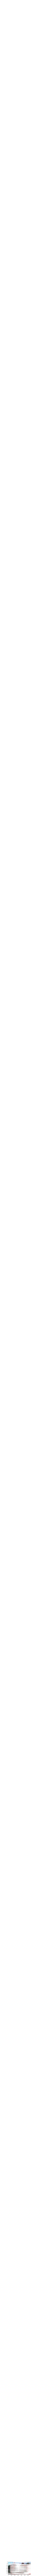

In [15]:
# summarize what we found
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Create a function to predict the bounding box with class probability in test set</span></h1><br>

In [17]:
def predict_bb_image(image):
    # define the expected input shape for the model
    input_w, input_h = 416, 416
    # define our new photo
    photo_filename = image
    # load and prepare image
    image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
    # make prediction
    yhat = model.predict(image)
    # summarize the shape of the list of arrays
    print([a.shape for a in yhat])
    
    # define the anchors
    anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
    # define the probability threshold for detected objects
    class_threshold = 0.6
    boxes = list()
    for i in range(len(yhat)):
        # decode the output of the network
        boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
        
    # correct the sizes of the bounding boxes for the shape of the image
    correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
    # suppress non-maximal boxes
#     do_nms(boxes, 0.5)
    # define the labels
    labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
        "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
        "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
        "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
        "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
        "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
        "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
        "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
        "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
        "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
    
    # get the details of the detected objects
    v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
    
    # summarize what we found
    for i in range(len(v_boxes)):
        print(v_labels[i], round(v_scores[i],2))
    # draw what we found
    draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Test Set prediction</span></h1><br>

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 63.0
backpack 63.74
spoon 60.12
sandwich 62.35
microwave 61.36
book 61.01
bicycle 66.34
car 61.46
bus 61.31
bench 65.79
bear 65.52
backpack 67.21
handbag 62.34
suitcase 64.7
baseball bat 66.16
surfboard 67.63
spoon 66.29
sandwich 67.6
pizza 65.09
mouse 64.91
remote 65.77
keyboard 61.17
microwave 63.56
book 64.3
handbag 62.71
baseball bat 62.66
surfboard 63.58
cup 61.5
spoon 62.13
bicycle 65.14
car 62.08
bus 64.52
truck 60.49
bench 65.18
bear 62.96
backpack 65.88
handbag 62.02
suitcase 64.74
baseball bat 63.17
surfboard 66.0
spoon 63.64
sandwich 65.39
pizza 65.31
cake 60.63
mouse 62.69
remote 61.45
keyboard 64.78
microwave 60.9
book 64.43
bus 66.53
truck 61.58
traffic light 66.81
parking meter 66.94
bench 64.21
horse 62.85
elephant 64.58
backpack 66.9
tie 64.19
suitcase 63.95
skis 65.19
bowl 66.64
apple 66.03
sandwich 61.74
pottedplant 60.95
diningtable 60.79
toilet 66.7
tvmonitor 63.12
clock 63.16
teddy bear 62.38
toothbrush 6

aeroplane 80.8
bus 79.08
traffic light 77.57
parking meter 81.45
bench 79.06
dog 77.11
sheep 77.57
cow 81.03
elephant 81.35
zebra 80.57
giraffe 73.85
backpack 81.39
handbag 67.05
tie 80.66
suitcase 81.44
skis 81.35
snowboard 67.11
sports ball 79.74
kite 81.37
baseball bat 65.07
bottle 81.03
bowl 81.22
carrot 78.41
hot dog 79.02
chair 64.03
pottedplant 77.0
bed 79.51
diningtable 79.39
toilet 78.34
tvmonitor 81.44
cell phone 63.89
microwave 60.18
book 72.56
teddy bear 81.43
toothbrush 81.42
car 80.62
aeroplane 80.19
bus 78.63
traffic light 77.65
parking meter 80.78
bench 78.34
dog 76.75
sheep 77.02
cow 80.35
elephant 80.7
zebra 79.92
giraffe 73.55
backpack 80.72
handbag 66.54
tie 80.07
suitcase 80.78
skis 80.71
snowboard 66.23
sports ball 79.23
kite 80.71
baseball bat 64.5
bottle 80.38
bowl 80.55
carrot 77.18
hot dog 78.23
chair 63.01
pottedplant 75.88
bed 79.05
diningtable 78.96
toilet 78.62
tvmonitor 80.78
cell phone 62.85
microwave 61.75
book 73.18
teddy bear 80.76
toothbrush 80.75
ca

kite 76.28
bottle 76.02
bowl 76.11
carrot 73.28
hot dog 73.92
pottedplant 70.64
bed 74.67
diningtable 74.31
toilet 72.68
tvmonitor 76.33
cell phone 60.05
book 70.21
teddy bear 76.32
toothbrush 76.3
car 76.45
aeroplane 76.05
bus 73.13
traffic light 73.18
parking meter 76.62
bench 74.15
dog 71.23
sheep 74.15
cow 76.35
elephant 76.53
zebra 75.13
giraffe 67.0
backpack 76.56
handbag 62.24
tie 75.95
suitcase 76.62
skis 76.55
sports ball 75.29
kite 76.57
bottle 76.2
bowl 76.4
carrot 73.16
hot dog 74.27
pottedplant 72.14
bed 74.89
diningtable 74.89
toilet 73.34
tvmonitor 76.62
cell phone 62.63
book 70.24
teddy bear 76.61
toothbrush 76.6
car 77.16
aeroplane 76.81
bus 72.7
traffic light 74.54
parking meter 77.32
bench 74.72
dog 71.97
sheep 75.15
cow 77.04
elephant 77.22
zebra 75.89
giraffe 67.02
backpack 77.25
handbag 62.87
tie 76.61
suitcase 77.32
skis 77.23
snowboard 60.42
sports ball 75.8
kite 77.27
bottle 76.84
bowl 77.07
carrot 74.12
hot dog 75.02
pottedplant 71.25
bed 75.75
diningtable 75.

aeroplane 68.68
bus 61.81
traffic light 66.39
parking meter 69.49
bench 60.17
dog 64.27
sheep 65.95
cow 67.99
elephant 69.39
zebra 64.77
giraffe 65.51
backpack 69.33
tie 68.31
suitcase 69.49
skis 69.44
sports ball 67.77
kite 69.48
bottle 69.24
bowl 68.72
carrot 68.18
hot dog 68.79
chair 60.0
pottedplant 63.66
bed 68.25
diningtable 68.45
tvmonitor 69.48
teddy bear 69.47
toothbrush 69.41
car 69.22
aeroplane 68.7
bus 62.21
traffic light 66.94
parking meter 69.53
bench 60.44
dog 63.99
sheep 66.3
cow 68.05
elephant 69.4
zebra 64.61
giraffe 65.65
backpack 69.33
tie 68.3
suitcase 69.53
skis 69.48
sports ball 67.91
kite 69.52
bottle 69.23
bowl 68.58
carrot 68.19
hot dog 68.85
pottedplant 63.17
bed 68.36
diningtable 68.52
tvmonitor 69.52
teddy bear 69.51
toothbrush 69.44
car 66.65
aeroplane 66.12
bus 61.38
traffic light 64.55
parking meter 66.88
dog 61.31
sheep 64.28
cow 65.68
elephant 66.78
zebra 61.23
giraffe 63.28
backpack 66.58
tie 65.31
suitcase 66.88
skis 66.84
sports ball 65.1
kite 66.88

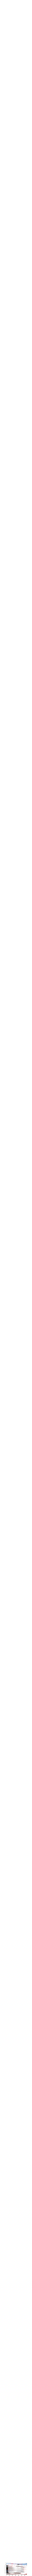

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.58
backpack 62.3
sandwich 60.92
bicycle 65.66
car 60.58
bus 60.47
bench 64.97
bear 64.81
backpack 66.35
handbag 61.99
suitcase 63.88
baseball bat 65.16
surfboard 66.77
spoon 65.32
sandwich 66.78
pizza 64.1
mouse 64.13
remote 64.83
keyboard 60.76
microwave 62.78
book 63.4
handbag 61.82
baseball bat 61.77
surfboard 62.67
cup 60.69
spoon 61.24
bicycle 64.95
car 61.67
bus 64.2
bench 64.95
bear 62.6
backpack 65.59
handbag 61.71
suitcase 64.36
baseball bat 62.89
surfboard 65.72
spoon 63.32
sandwich 65.1
pizza 65.05
cake 60.65
mouse 62.44
remote 61.16
keyboard 64.47
microwave 60.49
book 64.17
bus 68.27
truck 62.85
traffic light 68.51
parking meter 68.65
bench 65.88
horse 64.05
elephant 66.32
backpack 68.56
tie 66.17
suitcase 65.91
skis 67.02
bowl 68.41
apple 67.79
sandwich 63.25
pottedplant 62.53
diningtable 62.4
toilet 68.41
tvmonitor 65.03
clock 64.89
teddy bear 63.54
toothbrush 69.06
bicycle 60.48
bus 61.11
bench 61.36
backpack

elephant 75.98
zebra 74.69
giraffe 67.08
backpack 75.91
handbag 60.38
tie 75.1
suitcase 76.04
skis 75.92
sports ball 74.21
kite 75.99
baseball bat 60.58
bottle 75.63
bowl 75.8
carrot 72.66
hot dog 74.19
pottedplant 70.19
bed 74.71
diningtable 74.77
toilet 73.41
tvmonitor 76.03
book 65.84
teddy bear 76.02
toothbrush 76.0
car 79.58
aeroplane 76.28
bus 69.53
traffic light 79.63
parking meter 80.21
bench 78.69
dog 60.79
sheep 79.76
cow 78.81
elephant 78.47
bear 79.17
giraffe 74.89
backpack 79.28
tie 78.3
suitcase 80.2
skis 79.67
snowboard 74.52
sports ball 61.69
kite 79.35
bottle 79.08
bowl 79.75
carrot 77.11
hot dog 76.05
bed 77.05
toilet 76.49
tvmonitor 79.75
remote 77.7
book 73.56
teddy bear 80.17
toothbrush 79.95
car 71.91
aeroplane 71.72
bus 70.09
traffic light 72.16
parking meter 72.46
bench 71.49
dog 68.14
sheep 68.99
cow 72.2
elephant 71.83
bear 62.6
zebra 65.84
giraffe 64.64
backpack 72.17
tie 71.0
suitcase 72.45
skis 72.31
kite 72.33
baseball bat 60.99
bottle 72.21
bowl 72.31
car

suitcase 77.66
skis 77.58
sports ball 76.31
kite 77.61
bottle 77.23
bowl 77.41
carrot 74.43
hot dog 75.47
pottedplant 72.95
bed 76.01
diningtable 75.99
toilet 74.48
tvmonitor 77.66
cell phone 63.57
book 70.29
teddy bear 77.65
toothbrush 77.63
car 79.22
aeroplane 78.76
bus 74.79
traffic light 76.45
parking meter 79.41
bench 77.01
dog 74.13
sheep 77.33
cow 79.09
elephant 79.31
zebra 77.96
giraffe 69.63
backpack 79.35
handbag 64.65
tie 78.61
suitcase 79.41
skis 79.34
snowboard 61.47
sports ball 77.93
kite 79.36
bottle 78.92
bowl 79.18
carrot 76.0
hot dog 77.19
chair 60.91
pottedplant 74.31
bed 77.56
diningtable 77.99
toilet 76.02
tvmonitor 79.41
cell phone 64.3
book 71.51
teddy bear 79.4
toothbrush 79.38
car 78.31
aeroplane 77.87
bus 73.7
traffic light 75.08
parking meter 78.48
bench 75.52
dog 72.81
sheep 76.11
cow 78.18
elephant 78.37
zebra 77.01
giraffe 68.43
backpack 78.41
handbag 63.13
tie 77.74
suitcase 78.48
skis 78.39
snowboard 62.67
sports ball 76.89
kite 78.43
bottle 77.98
bowl 7

donut 60.73
cell phone 62.37
sink 63.8
book 60.7
cup 60.68
tvmonitor 61.02
cell phone 61.27
sink 63.46
car 60.17
cup 61.9
spoon 61.31
carrot 62.95
donut 60.5
cell phone 62.28
sink 63.57
book 60.33
snowboard 60.02
cup 61.39
tvmonitor 61.54
cell phone 61.48
sink 63.77
car 60.72
dog 60.89
snowboard 60.43
spoon 60.51
carrot 62.98
cake 61.29
cell phone 62.32
sink 63.24
book 61.41
car 60.14
cup 62.24
spoon 61.43
carrot 63.15
donut 61.01
cell phone 62.53
sink 63.93
book 60.9
snowboard 60.61
cup 61.55
tvmonitor 61.76
cell phone 62.27
sink 64.23
carrot 61.4
cell phone 60.7
sink 61.66
carrot 60.12
sink 60.8
snowboard 60.35
cup 61.02
tvmonitor 61.56
cell phone 62.14
sink 64.11
carrot 61.15
cell phone 60.63
sink 61.38
car 60.08
cup 62.01
spoon 61.33
carrot 62.96
donut 60.56
cell phone 62.41
sink 63.74
book 60.49
cup 60.46
tvmonitor 60.86
cell phone 61.1
sink 63.42
cup 60.57
carrot 61.37
cell phone 60.92
sink 62.07
cup 60.56
tvmonitor 60.85
cell phone 60.8
sink 63.34
carrot 60.27
sink 60.5
cup 61.9

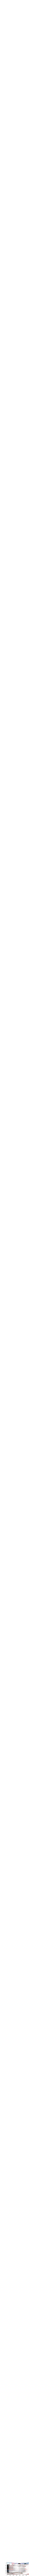

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.75
backpack 62.43
sandwich 61.02
microwave 60.07
bicycle 66.33
car 61.2
bus 61.66
bench 65.89
bear 65.63
backpack 67.17
handbag 62.52
suitcase 64.63
baseball bat 66.12
surfboard 67.6
spoon 66.21
sandwich 67.58
pizza 65.2
mouse 65.06
remote 65.71
keyboard 61.06
microwave 63.49
book 64.3
handbag 62.84
baseball bat 62.88
surfboard 63.66
cup 61.81
spoon 62.16
bicycle 64.39
car 61.57
bus 63.7
bench 64.28
bear 62.23
backpack 64.97
handbag 61.44
suitcase 63.76
baseball bat 62.25
surfboard 65.09
spoon 62.87
sandwich 64.47
pizza 64.51
mouse 62.03
remote 60.59
keyboard 63.91
microwave 60.17
book 63.58
bus 65.51
truck 60.58
traffic light 65.78
parking meter 65.94
bench 63.0
horse 61.26
elephant 63.54
backpack 65.87
tie 63.46
suitcase 63.3
skis 64.35
bowl 65.63
apple 64.93
sandwich 60.9
diningtable 60.64
toilet 65.73
tvmonitor 62.58
clock 62.39
teddy bear 61.1
toothbrush 66.3
bicycle 60.49
bus 61.25
bench 61.44
backpack 61.8
suitcase 6

tvmonitor 76.25
book 68.84
clock 61.04
teddy bear 76.23
toothbrush 76.23
car 81.69
aeroplane 81.34
bus 80.18
traffic light 78.65
parking meter 81.88
bench 79.49
dog 76.68
sheep 78.09
cow 81.46
elephant 81.78
zebra 81.13
giraffe 74.14
backpack 81.8
handbag 62.53
tie 81.02
suitcase 81.88
skis 81.79
snowboard 66.53
sports ball 80.42
kite 81.82
baseball bat 65.58
bottle 81.62
bowl 81.66
carrot 78.58
hot dog 78.66
pottedplant 77.24
bed 80.21
diningtable 79.33
toilet 79.17
tvmonitor 81.88
cell phone 65.25
microwave 63.32
book 75.09
clock 62.6
teddy bear 81.87
toothbrush 81.85
car 80.0
aeroplane 79.65
bus 77.67
traffic light 76.98
parking meter 80.18
bench 77.6
dog 75.99
sheep 76.81
cow 79.76
elephant 80.1
zebra 79.3
giraffe 71.39
backpack 80.11
handbag 64.14
tie 79.37
suitcase 80.18
skis 80.1
snowboard 64.64
sports ball 78.65
kite 80.12
baseball bat 62.64
bottle 79.78
bowl 79.99
carrot 76.87
hot dog 77.58
chair 61.87
pottedplant 75.64
bed 78.62
diningtable 77.97
toilet 77.65
tvmonitor 80.18


bowl 74.36
carrot 71.71
hot dog 72.03
pottedplant 69.23
bed 72.89
diningtable 72.56
toilet 70.67
tvmonitor 74.56
book 68.1
teddy bear 74.55
toothbrush 74.53
car 76.21
aeroplane 75.72
bus 72.83
traffic light 73.24
parking meter 76.39
bench 73.89
dog 70.5
sheep 74.2
cow 76.1
elephant 76.29
zebra 74.99
giraffe 67.59
backpack 76.33
handbag 62.15
tie 75.62
suitcase 76.39
skis 76.31
sports ball 74.79
kite 76.34
bottle 75.98
bowl 76.14
carrot 73.21
hot dog 73.95
pottedplant 71.68
bed 74.89
diningtable 74.5
toilet 73.16
tvmonitor 76.38
cell phone 62.47
book 69.6
teddy bear 76.37
toothbrush 76.36
car 79.44
aeroplane 79.05
bus 75.14
traffic light 76.51
parking meter 79.61
bench 77.12
dog 74.51
sheep 77.28
cow 79.3
elephant 79.52
zebra 78.15
giraffe 69.78
backpack 79.56
handbag 65.29
tie 78.8
suitcase 79.61
skis 79.53
snowboard 60.32
sports ball 78.26
kite 79.56
bottle 79.11
bowl 79.36
carrot 76.31
hot dog 77.4
chair 60.64
pottedplant 74.35
bed 77.95
diningtable 77.83
toilet 75.81
tvmonitor 79.61

pottedplant 63.91
bed 69.28
diningtable 69.12
tvmonitor 70.28
book 60.67
teddy bear 70.27
toothbrush 70.2
car 65.65
aeroplane 65.12
bus 60.28
traffic light 63.26
parking meter 65.88
dog 60.28
sheep 62.8
cow 64.89
elephant 65.77
giraffe 62.63
backpack 65.59
tie 64.38
suitcase 65.89
skis 65.84
sports ball 64.13
kite 65.88
bottle 65.58
bowl 64.73
carrot 64.62
hot dog 65.24
bed 65.14
diningtable 65.11
tvmonitor 65.88
teddy bear 65.87
toothbrush 65.78
car 62.14
aeroplane 60.7
parking meter 63.54
sheep 63.41
cow 62.74
elephant 61.57
bear 62.85
giraffe 60.05
suitcase 63.56
skis 62.48
snowboard 63.29
kite 62.28
bottle 60.96
bowl 60.66
hot dog 63.4
bed 61.34
tvmonitor 61.32
teddy bear 63.53
toothbrush 61.65
sink 60.39
sink 61.38
cup 61.03
spoon 60.11
carrot 61.73
cell phone 61.13
sink 62.41
sink 60.71
car 60.15
cup 62.39
spoon 61.43
carrot 63.07
donut 61.47
cell phone 62.51
sink 63.91
book 60.61
sink 61.7
carrot 60.06
sink 60.3
cup 60.24
carrot 61.05
cell phone 60.54
sink 61.83
snowboard 60.01


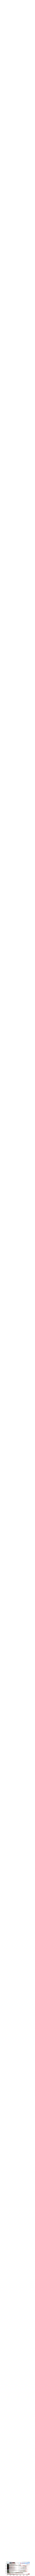

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.19
backpack 62.96
sandwich 61.58
microwave 60.59
book 60.2
bicycle 66.03
car 60.91
bus 60.73
bench 65.56
bear 65.26
backpack 66.87
handbag 62.4
suitcase 64.23
baseball bat 65.59
surfboard 67.23
spoon 65.93
sandwich 67.21
pizza 64.61
mouse 64.77
remote 65.38
keyboard 61.36
microwave 63.55
book 63.85
handbag 63.07
baseball bat 63.02
surfboard 63.98
cup 61.87
spoon 62.5
keyboard 60.24
bicycle 65.33
car 62.28
bus 64.38
truck 60.64
bench 65.2
bear 63.33
backpack 65.98
handbag 62.4
suitcase 64.8
baseball bat 63.47
surfboard 66.11
spoon 63.62
sandwich 65.53
pizza 65.54
cake 61.03
mouse 62.81
remote 61.34
keyboard 64.93
microwave 61.09
book 64.53
bus 68.18
truck 63.25
traffic light 68.39
parking meter 68.55
bench 65.57
horse 64.08
elephant 66.31
backpack 68.55
tie 65.98
suitcase 66.07
skis 67.02
bowl 68.33
apple 67.59
sandwich 63.26
pottedplant 61.64
diningtable 62.55
toilet 68.27
tvmonitor 64.88
clock 64.91
teddy bear 63.81
toothb

bench 77.71
dog 76.17
sheep 76.54
cow 80.03
elephant 80.36
zebra 79.58
giraffe 72.43
backpack 80.38
handbag 64.54
tie 79.52
suitcase 80.43
skis 80.34
snowboard 64.25
sports ball 78.84
kite 80.38
baseball bat 62.48
bottle 79.98
bowl 80.2
carrot 77.58
hot dog 77.78
chair 66.0
pottedplant 74.35
bed 78.46
diningtable 78.66
toilet 77.48
tvmonitor 80.43
cell phone 64.14
book 72.23
teddy bear 80.41
toothbrush 80.41
person 61.04
car 83.34
aeroplane 82.84
bus 80.66
traffic light 80.82
parking meter 83.5
bench 80.91
dog 78.48
sheep 79.56
cow 83.15
elephant 83.4
zebra 82.54
giraffe 75.69
backpack 83.43
handbag 67.21
tie 82.74
suitcase 83.5
skis 83.42
snowboard 69.27
sports ball 81.93
kite 83.44
baseball bat 65.3
bottle 83.01
bowl 83.22
carrot 79.76
hot dog 80.85
chair 62.4
pottedplant 77.29
bed 82.09
diningtable 81.66
toilet 81.02
tvmonitor 83.49
cell phone 66.85
microwave 63.75
refrigerator 61.1
book 74.98
clock 60.61
teddy bear 83.47
toothbrush 83.46
car 72.84
aeroplane 72.44
bus 71.01
traffic 

elephant 74.17
zebra 73.15
giraffe 66.37
backpack 74.19
tie 73.4
suitcase 74.29
skis 74.21
sports ball 73.05
kite 74.25
bottle 74.0
bowl 74.03
carrot 71.29
hot dog 71.7
pottedplant 68.14
bed 72.61
diningtable 72.44
toilet 70.85
tvmonitor 74.29
book 68.24
teddy bear 74.28
toothbrush 74.27
car 74.17
aeroplane 73.82
bus 70.66
traffic light 71.38
parking meter 74.37
bench 72.3
dog 69.05
sheep 72.09
cow 74.1
elephant 74.28
zebra 72.95
giraffe 66.11
backpack 74.3
handbag 61.09
tie 73.58
suitcase 74.37
skis 74.29
sports ball 72.89
kite 74.33
bottle 74.04
bowl 74.14
carrot 71.11
hot dog 72.17
pottedplant 68.35
bed 72.68
diningtable 72.63
toilet 71.01
tvmonitor 74.37
book 67.89
teddy bear 74.36
toothbrush 74.35
car 76.22
aeroplane 75.94
bus 72.41
traffic light 73.37
parking meter 76.42
bench 74.16
dog 71.36
sheep 74.07
cow 76.17
elephant 76.32
zebra 74.89
giraffe 67.31
backpack 76.36
handbag 62.2
tie 75.62
suitcase 76.42
skis 76.33
sports ball 75.01
kite 76.38
bottle 76.01
bowl 76.17
carrot 73.

cake 61.3
tvmonitor 60.5
cell phone 64.47
sink 65.8
book 61.47
spoon 60.94
carrot 61.67
donut 60.28
cake 61.31
cell phone 61.49
sink 61.82
car 60.62
spoon 60.99
carrot 62.27
donut 60.6
cake 61.55
cell phone 62.08
sink 62.47
car 63.21
umbrella 61.55
snowboard 60.0
cup 64.42
knife 63.73
spoon 66.1
carrot 66.35
donut 64.88
cake 63.16
tvmonitor 62.74
cell phone 66.5
sink 67.36
tvmonitor 60.03
cell phone 61.97
sink 63.52
carrot 60.91
cake 60.3
cell phone 60.9
carrot 61.37
donut 60.55
cake 60.95
cell phone 61.17
carrot 60.25
cell phone 60.09
carrot 60.57
cake 60.04
cell phone 60.32
car 60.51
umbrella 60.4
cup 62.22
knife 61.58
spoon 60.87
carrot 64.64
donut 62.44
cake 63.46
cell phone 64.54
sink 63.56
book 60.91
knife 61.09
carrot 63.13
cake 62.01
cell phone 62.5
sink 61.63
umbrella 63.52
cup 65.28
knife 63.83
spoon 63.38
carrot 64.64
donut 62.56
cake 61.74
tvmonitor 61.2
cell phone 64.81
sink 64.52
truck 60.8
horse 60.94
skateboard 65.85
carrot 65.86
donut 64.77
cake 68.21
tvmonitor 64.97
c

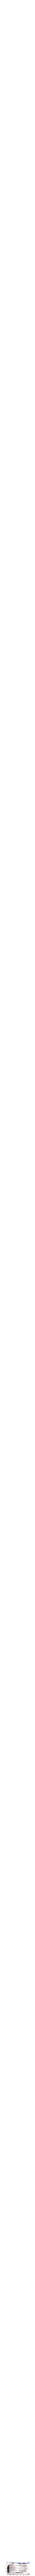

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.85
backpack 62.59
sandwich 61.29
microwave 60.31
book 60.0
bicycle 64.75
car 60.07
bench 64.2
bear 63.96
backpack 65.51
handbag 61.17
suitcase 63.23
baseball bat 64.46
surfboard 66.0
spoon 64.71
sandwich 65.96
pizza 63.35
mouse 63.43
remote 64.18
microwave 62.2
book 62.68
handbag 63.93
baseball bat 63.98
surfboard 64.88
cup 62.71
spoon 63.33
keyboard 61.19
microwave 60.05
bicycle 66.18
car 63.04
bus 65.55
truck 60.99
bench 66.12
bear 63.69
backpack 66.84
handbag 63.03
suitcase 65.69
baseball bat 63.92
surfboard 66.98
spoon 64.61
sandwich 66.36
pizza 66.31
cake 61.43
mouse 63.55
remote 62.09
keyboard 65.77
microwave 62.05
book 65.34
bus 68.16
truck 62.35
traffic light 68.4
parking meter 68.49
bench 65.62
horse 64.03
elephant 66.0
backpack 68.52
tie 66.23
suitcase 65.71
skis 66.98
bowl 68.27
apple 67.62
sandwich 63.21
pottedplant 61.87
diningtable 62.79
toilet 68.25
tvmonitor 64.66
clock 64.76
teddy bear 63.73
toothbrush 68.9

tvmonitor 78.95
book 72.6
clock 65.2
teddy bear 78.94
toothbrush 78.93
car 81.03
aeroplane 80.65
bus 79.42
traffic light 77.46
parking meter 81.22
bench 79.03
dog 76.75
sheep 77.69
cow 80.85
elephant 81.12
zebra 80.49
giraffe 74.69
backpack 81.12
handbag 61.12
tie 80.4
suitcase 81.22
skis 81.12
snowboard 65.48
sports ball 79.86
kite 81.16
baseball bat 64.82
bottle 80.9
bowl 81.0
carrot 77.56
hot dog 78.61
pottedplant 75.5
bed 79.47
diningtable 78.86
toilet 78.2
tvmonitor 81.21
cell phone 63.03
microwave 61.94
book 74.63
clock 60.96
teddy bear 81.2
toothbrush 81.18
car 80.02
aeroplane 79.55
bus 77.76
traffic light 77.03
parking meter 80.18
bench 77.35
dog 76.16
sheep 76.82
cow 79.81
elephant 80.1
zebra 79.3
giraffe 72.42
backpack 80.12
handbag 64.59
tie 79.46
suitcase 80.18
skis 80.11
snowboard 65.99
sports ball 78.53
kite 80.12
baseball bat 64.3
bottle 79.77
bowl 79.96
carrot 76.57
hot dog 77.53
chair 63.42
pottedplant 75.61
bed 78.47
diningtable 78.37
toilet 77.59
tvmonitor 80.18
cell

zebra 78.81
giraffe 70.92
backpack 80.37
handbag 65.52
tie 79.72
suitcase 80.43
skis 80.36
snowboard 62.26
sports ball 78.9
kite 80.37
bottle 79.98
bowl 80.21
carrot 77.31
hot dog 77.87
chair 63.82
pottedplant 75.3
bed 78.8
diningtable 78.44
toilet 77.18
tvmonitor 80.42
cell phone 64.47
book 72.73
teddy bear 80.41
toothbrush 80.4
car 76.97
aeroplane 76.5
bus 72.03
traffic light 74.1
parking meter 77.15
bench 74.49
dog 71.86
sheep 74.88
cow 76.84
elephant 77.06
zebra 75.59
giraffe 67.71
backpack 77.08
handbag 62.32
tie 76.49
suitcase 77.15
skis 77.05
snowboard 61.16
sports ball 75.7
kite 77.09
bottle 76.68
bowl 76.93
carrot 74.15
hot dog 74.86
chair 60.69
pottedplant 71.59
bed 75.52
diningtable 75.45
toilet 73.47
tvmonitor 77.14
book 70.45
teddy bear 77.13
toothbrush 77.12
car 78.07
aeroplane 77.59
bus 73.47
traffic light 75.51
parking meter 78.23
bench 75.23
dog 72.52
sheep 75.64
cow 77.94
elephant 78.12
zebra 76.69
giraffe 68.83
backpack 78.16
handbag 61.73
tie 77.48
suitcase 78.23
sk

bus 70.16
traffic light 68.92
parking meter 72.4
bench 69.47
dog 66.62
sheep 69.13
cow 72.02
elephant 72.27
zebra 71.16
giraffe 64.5
backpack 72.31
tie 71.01
suitcase 72.4
skis 72.34
sports ball 71.58
kite 72.37
bottle 72.22
bowl 72.0
carrot 68.46
hot dog 69.12
pottedplant 66.95
bed 71.0
diningtable 71.16
toilet 69.24
tvmonitor 72.4
book 66.91
teddy bear 72.38
toothbrush 72.37
car 75.55
aeroplane 75.17
bus 72.94
traffic light 72.37
parking meter 75.71
bench 72.37
dog 70.36
sheep 72.39
cow 75.34
elephant 75.61
zebra 74.14
giraffe 66.92
backpack 75.64
handbag 62.69
tie 74.26
suitcase 75.71
skis 75.65
sports ball 74.71
kite 75.68
bottle 75.51
bowl 75.27
carrot 71.3
hot dog 72.58
chair 60.44
pottedplant 70.34
bed 73.97
diningtable 74.67
toilet 71.97
tvmonitor 75.7
book 70.26
teddy bear 75.69
toothbrush 75.68
car 77.3
aeroplane 76.89
bus 73.79
traffic light 73.96
parking meter 77.46
bench 74.56
dog 72.44
sheep 73.93
cow 77.08
elephant 77.35
zebra 75.99
giraffe 67.7
backpack 77.4
handbag 64.

cake 60.62
tvmonitor 61.44
cell phone 61.66
sink 62.09
skateboard 61.56
carrot 60.25
donut 61.98
cake 61.61
tvmonitor 62.42
cell phone 62.47
sink 62.87
toaster 61.88
clock 62.04
skateboard 61.22
donut 61.63
cake 61.06
tvmonitor 61.94
cell phone 62.22
sink 62.68
toaster 60.05
clock 60.09
skateboard 62.25
carrot 60.71
donut 62.62
cake 62.26
tvmonitor 62.86
cell phone 63.06
sink 63.54
toaster 60.19
clock 60.17
skateboard 61.87
carrot 60.35
donut 62.4
cake 61.85
tvmonitor 62.4
cell phone 62.81
sink 63.07
skateboard 61.31
donut 61.78
cake 61.36
tvmonitor 61.88
cell phone 62.54
sink 62.61
skateboard 61.46
donut 61.72
cake 61.07
tvmonitor 61.95
cell phone 62.15
sink 62.65
toaster 60.38
clock 60.41
skateboard 62.87
carrot 61.49
donut 63.07
cake 62.58
tvmonitor 63.57
cell phone 63.75
sink 64.2
toaster 61.14
clock 61.08
skateboard 61.07
donut 61.21
cake 60.87
tvmonitor 61.43
cell phone 61.81
sink 62.07
skateboard 61.78
carrot 60.38
donut 62.19
cake 61.62
tvmonitor 62.58
cell phone 62.97
sink 63.

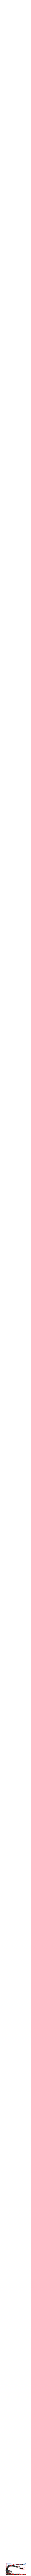

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.66
backpack 63.37
sandwich 61.97
microwave 60.89
book 60.63
bicycle 67.03
car 61.72
bus 61.76
bench 66.27
bear 66.26
backpack 67.78
handbag 63.53
tie 60.3
suitcase 65.02
baseball bat 66.64
surfboard 68.23
spoon 66.75
bowl 60.19
sandwich 68.23
pizza 65.57
mouse 65.57
remote 66.39
keyboard 61.41
microwave 64.2
book 64.67
handbag 63.3
baseball bat 63.2
surfboard 64.12
cup 62.02
spoon 62.51
keyboard 60.08
bicycle 67.61
car 64.5
bus 66.99
truck 62.62
bench 67.56
horse 61.07
bear 65.21
backpack 68.3
handbag 64.23
suitcase 67.14
baseball bat 65.56
surfboard 68.46
spoon 65.96
sandwich 67.76
pizza 67.86
cake 62.42
mouse 65.24
remote 63.68
keyboard 67.16
microwave 63.15
sink 60.83
book 66.53
bus 66.19
truck 60.56
traffic light 66.49
parking meter 66.62
bench 63.66
horse 62.31
elephant 64.6
backpack 66.55
tie 64.32
suitcase 64.25
skis 64.93
bowl 66.4
apple 65.86
sandwich 61.81
pottedplant 61.2
diningtable 60.34
toilet 66.5
tvmonitor 6

backpack 85.11
handbag 69.96
tie 84.3
suitcase 85.18
skis 85.06
snowboard 67.99
sports ball 84.03
kite 85.02
baseball bat 68.15
bottle 84.31
bowl 84.91
carrot 77.8
hot dog 83.33
chair 71.09
pottedplant 75.51
bed 83.43
diningtable 83.06
toilet 83.14
tvmonitor 85.17
refrigerator 69.17
book 69.67
clock 67.93
teddy bear 85.14
toothbrush 85.14
person 61.92
car 76.96
aeroplane 76.58
bus 75.13
traffic light 75.86
parking meter 77.14
bench 74.45
dog 71.96
sheep 73.54
cow 76.89
elephant 77.09
zebra 76.49
giraffe 66.0
backpack 77.03
handbag 63.26
tie 75.95
suitcase 77.14
skis 76.98
sports ball 75.87
kite 77.02
bottle 76.39
bowl 76.83
carrot 70.58
hot dog 75.96
pottedplant 67.61
bed 75.95
diningtable 75.15
toilet 75.22
tvmonitor 77.13
refrigerator 62.07
book 61.93
clock 60.74
teddy bear 77.11
toothbrush 77.1
car 80.83
aeroplane 76.88
bus 74.24
traffic light 80.91
parking meter 81.47
bench 80.0
dog 63.74
sheep 80.87
cow 80.0
elephant 79.63
bear 80.18
zebra 64.52
giraffe 76.69
backpack 80.74
tie 79

dog 74.5
sheep 77.88
cow 79.94
elephant 80.15
zebra 78.87
giraffe 70.25
backpack 80.18
handbag 63.93
tie 79.55
suitcase 80.24
skis 80.16
snowboard 62.18
sports ball 78.8
kite 80.19
bottle 79.8
bowl 80.03
carrot 76.91
hot dog 78.02
chair 62.03
pottedplant 75.52
bed 78.65
diningtable 78.16
toilet 76.61
tvmonitor 80.23
cell phone 62.78
book 72.82
teddy bear 80.22
toothbrush 80.21
car 78.71
aeroplane 78.25
bus 74.26
traffic light 76.11
parking meter 78.89
bench 76.2
dog 73.37
sheep 76.14
cow 78.57
elephant 78.8
zebra 77.36
giraffe 68.56
backpack 78.83
handbag 63.53
tie 78.19
suitcase 78.89
skis 78.81
snowboard 61.14
sports ball 77.18
kite 78.84
bottle 78.38
bowl 78.69
carrot 75.37
hot dog 76.81
chair 61.51
pottedplant 73.4
bed 77.37
diningtable 77.14
toilet 75.4
tvmonitor 78.89
cell phone 61.79
book 71.42
teddy bear 78.87
toothbrush 78.86
car 77.63
aeroplane 77.15
bus 72.95
traffic light 75.29
parking meter 77.8
bench 75.07
dog 71.92
sheep 75.15
cow 77.52
elephant 77.7
zebra 76.15
giraffe 

parking meter 73.31
bench 70.07
dog 67.83
sheep 69.83
cow 73.01
elephant 73.21
zebra 71.9
giraffe 64.93
backpack 73.24
handbag 61.76
tie 71.94
suitcase 73.31
skis 73.26
sports ball 72.37
kite 73.29
bottle 73.12
bowl 72.79
carrot 69.66
hot dog 70.33
pottedplant 67.25
bed 72.03
diningtable 72.34
toilet 69.35
tvmonitor 73.31
book 68.21
teddy bear 73.29
toothbrush 73.28
car 67.65
aeroplane 67.39
bus 65.44
traffic light 65.97
parking meter 67.75
bench 64.82
dog 62.35
sheep 65.24
cow 67.45
elephant 67.69
zebra 65.92
backpack 67.62
tie 66.17
suitcase 67.75
skis 67.68
sports ball 66.53
kite 67.74
bottle 67.53
bowl 67.23
carrot 64.49
hot dog 65.7
pottedplant 63.17
bed 66.8
diningtable 67.07
toilet 64.5
tvmonitor 67.75
book 61.33
teddy bear 67.74
toothbrush 67.71
car 75.39
aeroplane 72.71
bus 60.5
traffic light 74.94
parking meter 76.48
bench 73.98
sheep 75.47
cow 75.49
elephant 75.48
bear 75.31
giraffe 73.3
backpack 73.61
tie 72.81
suitcase 76.5
skis 75.98
snowboard 72.89
sports ball 60.54
kite

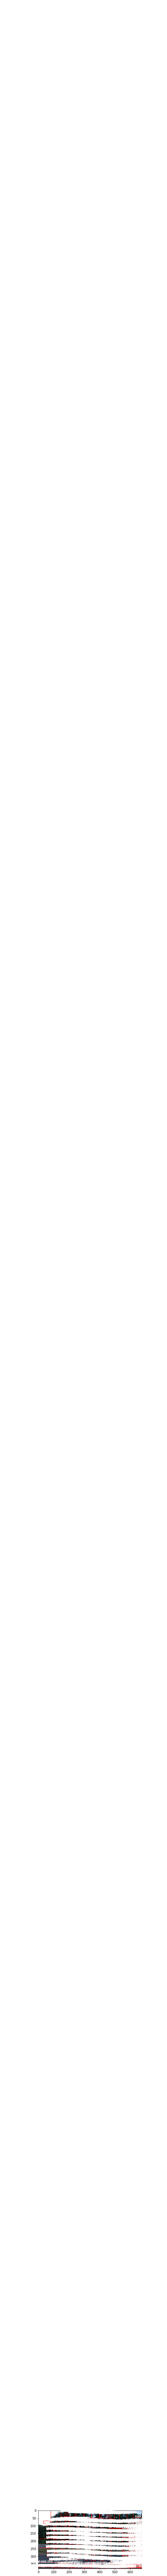

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.97
backpack 62.67
sandwich 61.42
microwave 60.24
bicycle 65.43
car 60.83
bus 60.39
bench 64.85
bear 64.68
backpack 66.17
handbag 61.73
suitcase 63.73
baseball bat 65.14
surfboard 66.65
spoon 65.29
sandwich 66.62
pizza 64.05
mouse 64.12
remote 64.9
keyboard 60.38
microwave 62.79
book 63.36
handbag 62.47
baseball bat 62.43
surfboard 63.27
cup 61.22
spoon 61.78
bicycle 66.08
car 62.79
bus 65.34
truck 61.19
bench 66.07
bear 64.07
backpack 66.77
handbag 63.15
suitcase 65.63
baseball bat 64.22
surfboard 66.9
spoon 64.56
sandwich 66.31
pizza 66.3
cake 61.26
mouse 63.69
remote 62.43
keyboard 65.67
microwave 61.95
sink 60.0
book 65.18
bus 66.84
truck 61.44
traffic light 67.2
parking meter 67.28
bench 64.54
horse 62.87
elephant 65.14
backpack 67.22
tie 64.98
suitcase 64.76
skis 65.65
bowl 67.06
apple 66.44
sandwich 62.3
pottedplant 61.21
diningtable 61.68
toilet 66.99
tvmonitor 63.42
clock 63.58
teddy bear 62.85
toothbrush 67.66
bicy

traffic light 75.29
parking meter 75.61
bench 74.41
dog 70.91
sheep 69.93
cow 75.34
elephant 75.03
bear 62.92
zebra 70.74
giraffe 67.63
backpack 75.38
tie 73.76
suitcase 75.61
skis 75.41
sports ball 61.64
kite 75.45
baseball bat 66.34
bottle 75.4
bowl 75.42
carrot 74.06
hot dog 73.37
bed 61.4
diningtable 70.01
toilet 74.43
tvmonitor 75.59
teddy bear 75.6
toothbrush 75.56
car 77.65
aeroplane 77.54
bus 77.02
traffic light 73.26
parking meter 77.88
bench 75.21
dog 74.47
sheep 73.55
cow 77.46
elephant 77.65
zebra 76.93
giraffe 70.31
backpack 77.73
handbag 60.09
tie 77.11
suitcase 77.88
skis 77.78
snowboard 65.37
sports ball 75.73
kite 77.82
baseball bat 67.45
bottle 77.58
bowl 77.67
carrot 75.92
hot dog 76.06
pottedplant 71.25
bed 74.97
diningtable 74.72
toilet 75.31
tvmonitor 77.87
book 71.0
clock 63.64
teddy bear 77.85
toothbrush 77.85
car 78.61
aeroplane 78.3
bus 77.21
traffic light 75.62
parking meter 78.79
bench 76.12
dog 74.44
sheep 75.33
cow 78.43
elephant 78.72
zebra 78.17
giraffe 

tie 74.98
suitcase 75.73
skis 75.66
sports ball 74.48
kite 75.69
bottle 75.43
bowl 75.5
carrot 72.95
hot dog 73.15
pottedplant 70.83
bed 74.28
diningtable 73.72
toilet 72.09
tvmonitor 75.73
book 69.99
teddy bear 75.72
toothbrush 75.71
car 76.26
aeroplane 75.87
bus 72.61
traffic light 73.14
parking meter 76.44
bench 74.05
dog 71.33
sheep 74.4
cow 76.16
elephant 76.36
zebra 75.07
giraffe 66.94
backpack 76.37
handbag 61.32
tie 75.68
suitcase 76.44
skis 76.35
snowboard 60.49
sports ball 75.02
kite 76.39
bottle 75.98
bowl 76.2
carrot 73.47
hot dog 74.14
pottedplant 71.77
bed 74.83
diningtable 74.71
toilet 72.99
tvmonitor 76.44
cell phone 60.93
book 69.23
teddy bear 76.43
toothbrush 76.42
car 78.72
aeroplane 78.31
bus 74.34
traffic light 75.71
parking meter 78.92
bench 76.49
dog 73.2
sheep 76.6
cow 78.65
elephant 78.82
zebra 77.41
giraffe 68.65
backpack 78.86
handbag 63.78
tie 78.18
suitcase 78.92
skis 78.83
snowboard 60.07
sports ball 77.39
kite 78.86
bottle 78.49
bowl 78.68
carrot 75.58
ho

teddy bear 71.58
toothbrush 71.52
car 71.85
aeroplane 71.25
bus 64.87
traffic light 69.32
parking meter 72.17
bench 61.63
dog 66.76
sheep 68.78
cow 70.74
elephant 72.02
zebra 66.85
giraffe 67.77
backpack 71.94
tie 70.91
suitcase 72.17
skis 72.12
snowboard 61.16
sports ball 70.47
kite 72.16
bottle 71.86
bowl 70.97
carrot 70.89
hot dog 71.48
chair 60.01
pottedplant 65.42
bed 70.98
diningtable 70.95
tvmonitor 72.16
book 61.3
teddy bear 72.15
toothbrush 72.07
car 69.65
aeroplane 68.97
bus 63.7
traffic light 67.2
parking meter 69.89
bench 60.01
dog 63.84
sheep 66.87
cow 68.79
elephant 69.77
zebra 63.75
giraffe 66.24
backpack 69.61
tie 68.2
suitcase 69.9
skis 69.85
sports ball 67.9
kite 69.89
bottle 69.59
bowl 68.54
carrot 68.46
hot dog 69.27
pottedplant 63.11
bed 69.04
diningtable 69.02
tvmonitor 69.88
teddy bear 69.88
toothbrush 69.77
parking meter 61.37
sheep 61.24
cow 60.6
bear 60.63
suitcase 61.39
skis 60.44
snowboard 61.12
kite 60.3
hot dog 61.25
teddy bear 61.37
cup 60.6
sink 61.35
cu

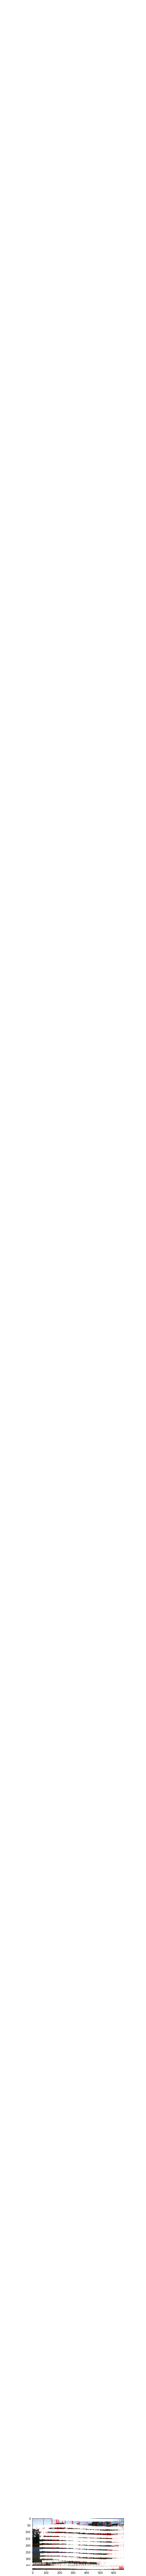

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.29
backpack 62.93
sandwich 61.6
microwave 60.64
book 60.18
bicycle 66.96
car 61.96
bus 62.07
bench 66.24
bear 66.27
backpack 67.68
handbag 63.22
tie 60.56
suitcase 65.07
baseball bat 66.7
surfboard 68.21
spoon 66.88
bowl 60.18
sandwich 68.2
pizza 65.66
mouse 65.51
remote 66.15
keyboard 61.12
microwave 64.44
book 64.7
handbag 60.91
baseball bat 60.87
surfboard 61.82
spoon 60.43
bicycle 65.63
car 62.63
bus 65.0
truck 60.85
bench 65.53
bear 63.77
backpack 66.33
handbag 62.04
suitcase 65.22
baseball bat 63.28
surfboard 66.46
spoon 64.18
sandwich 65.79
pizza 65.75
cake 61.01
mouse 63.16
remote 61.47
keyboard 65.3
microwave 61.56
book 64.83
bus 67.13
truck 62.03
traffic light 67.3
parking meter 67.43
bench 64.27
horse 62.54
elephant 65.11
backpack 67.37
tie 64.6
suitcase 64.55
skis 65.89
bowl 67.14
apple 66.43
sandwich 61.94
pottedplant 61.0
diningtable 61.53
toilet 67.22
tvmonitor 63.94
clock 64.1
teddy bear 62.41
toothbrush 67.

pottedplant 75.55
bed 79.14
diningtable 78.54
toilet 77.88
tvmonitor 80.82
cell phone 63.42
book 73.56
clock 60.59
teddy bear 80.8
toothbrush 80.79
car 78.99
aeroplane 78.61
bus 76.81
traffic light 75.76
parking meter 79.15
bench 76.68
dog 75.05
sheep 75.33
cow 78.71
elephant 79.06
zebra 78.25
giraffe 71.66
backpack 79.09
handbag 63.1
tie 78.32
suitcase 79.15
skis 79.06
snowboard 63.51
sports ball 77.63
kite 79.09
bottle 78.78
bowl 78.93
carrot 75.53
hot dog 77.04
pottedplant 74.64
bed 77.33
diningtable 77.09
toilet 76.79
tvmonitor 79.14
cell phone 63.01
book 71.24
teddy bear 79.13
toothbrush 79.12
car 81.69
aeroplane 81.18
bus 79.03
traffic light 77.87
parking meter 81.86
bench 79.36
dog 76.96
sheep 78.02
cow 81.51
elephant 81.77
zebra 80.85
giraffe 73.07
backpack 81.81
handbag 65.53
tie 81.12
suitcase 81.86
skis 81.79
snowboard 65.23
sports ball 80.4
kite 81.8
baseball bat 65.31
bottle 81.41
bowl 81.63
carrot 78.55
hot dog 78.94
chair 62.59
pottedplant 76.26
bed 79.93
diningtable 79.

giraffe 67.46
backpack 77.72
handbag 61.74
tie 76.93
suitcase 77.79
skis 77.71
snowboard 61.24
sports ball 76.22
kite 77.75
bottle 77.35
bowl 77.55
carrot 74.43
hot dog 75.37
chair 60.35
pottedplant 72.53
bed 76.26
diningtable 75.63
toilet 73.85
tvmonitor 77.79
cell phone 62.49
book 71.18
teddy bear 77.78
toothbrush 77.77
person 60.42
car 80.94
aeroplane 80.47
bus 76.41
traffic light 77.98
parking meter 81.12
bench 78.37
dog 75.5
sheep 78.53
cow 80.8
elephant 81.02
zebra 79.57
giraffe 71.58
backpack 81.06
handbag 65.57
tie 80.36
suitcase 81.12
skis 81.04
snowboard 62.78
sports ball 79.64
kite 81.07
bottle 80.58
bowl 80.88
carrot 77.07
hot dog 78.51
chair 62.42
pottedplant 75.09
bed 79.5
diningtable 79.03
toilet 77.01
tvmonitor 81.12
cell phone 63.46
book 73.49
teddy bear 81.11
toothbrush 81.1
car 79.86
aeroplane 79.46
bus 75.69
traffic light 77.01
parking meter 80.05
bench 77.54
dog 74.18
sheep 77.35
cow 79.77
elephant 79.95
zebra 78.63
giraffe 70.4
backpack 79.98
handbag 64.87
tie 79.

teddy bear 67.99
toothbrush 67.9
car 60.45
parking meter 61.91
sheep 61.8
cow 61.15
bear 61.24
suitcase 61.92
skis 60.83
snowboard 61.65
kite 60.82
hot dog 61.76
teddy bear 61.9
sink 60.92
sink 60.11
car 60.54
dog 60.85
snowboard 60.65
spoon 60.25
carrot 62.73
cake 61.45
cell phone 62.11
sink 62.9
book 61.48
car 61.09
umbrella 60.2
cup 63.0
knife 60.1
spoon 61.95
carrot 63.85
donut 61.67
cell phone 62.89
sink 64.53
book 61.78
snowboard 60.27
cup 61.67
tvmonitor 61.52
cell phone 62.1
sink 64.4
cup 62.14
spoon 61.62
carrot 63.15
donut 61.24
cell phone 62.44
sink 63.84
book 60.59
snowboard 61.03
cup 62.37
tvmonitor 62.23
cell phone 62.65
sink 65.23
cup 60.94
spoon 60.1
carrot 61.81
cell phone 61.14
sink 62.54
cup 60.67
tvmonitor 60.73
cell phone 61.26
sink 63.62
cup 60.06
carrot 61.26
cell phone 60.77
sink 61.99
snowboard 60.09
cup 61.05
tvmonitor 61.31
cell phone 61.84
sink 63.89
cup 61.18
spoon 60.79
carrot 62.27
cell phone 61.56
sink 62.97
book 60.06
cup 60.3
tvmonitor 60.63
cell phone

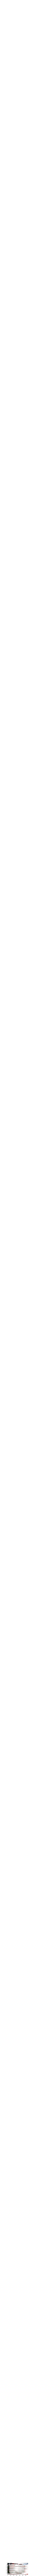

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.07
backpack 62.82
sandwich 61.33
microwave 60.63
book 60.01
bicycle 65.81
car 61.15
bus 60.68
bench 65.27
bear 65.3
backpack 66.72
handbag 62.39
suitcase 64.27
baseball bat 65.62
surfboard 67.15
spoon 65.71
sandwich 67.1
pizza 64.36
mouse 64.47
remote 65.19
keyboard 61.17
microwave 63.25
book 63.99
handbag 62.79
baseball bat 62.75
surfboard 63.68
cup 61.5
spoon 62.34
keyboard 60.1
bicycle 65.45
car 62.34
bus 64.74
truck 60.76
bench 65.43
bear 63.03
backpack 66.14
handbag 62.12
suitcase 64.89
baseball bat 63.54
surfboard 66.28
spoon 63.92
sandwich 65.62
pizza 65.57
cake 60.43
mouse 62.97
remote 61.31
keyboard 65.1
microwave 61.23
book 64.62
bus 67.67
truck 62.23
traffic light 67.81
parking meter 68.05
bench 64.96
horse 63.42
elephant 65.94
backpack 68.03
tie 65.71
suitcase 65.26
skis 66.35
bowl 67.83
apple 67.08
sandwich 62.78
pottedplant 62.04
diningtable 61.71
toilet 67.84
tvmonitor 64.82
clock 64.35
teddy bear 63.53
tooth

sports ball 81.77
kite 83.51
baseball bat 65.63
bottle 83.12
bowl 83.36
carrot 79.94
hot dog 80.98
chair 63.7
pottedplant 77.59
bed 81.79
diningtable 81.48
toilet 80.82
tvmonitor 83.57
cell phone 65.91
microwave 62.69
book 74.89
clock 61.43
teddy bear 83.55
toothbrush 83.54
car 83.95
aeroplane 83.48
bus 80.82
traffic light 80.85
parking meter 84.12
bench 80.98
dog 78.75
sheep 80.02
cow 83.76
elephant 83.99
zebra 82.8
giraffe 74.77
backpack 84.05
handbag 69.66
tie 83.29
suitcase 84.12
skis 84.04
snowboard 71.31
sports ball 82.59
kite 84.06
baseball bat 64.53
bottle 83.62
bowl 83.85
carrot 80.82
hot dog 81.23
chair 61.66
pottedplant 77.08
bed 82.46
diningtable 82.39
toilet 81.32
tvmonitor 84.11
cell phone 65.78
microwave 64.7
book 75.29
clock 63.21
teddy bear 84.1
toothbrush 84.08
car 76.21
aeroplane 75.89
bus 74.08
traffic light 74.58
parking meter 76.35
bench 73.61
dog 70.99
sheep 72.7
cow 76.03
elephant 76.28
zebra 75.05
giraffe 67.37
backpack 76.22
handbag 62.47
tie 75.16
suitcase 76

skis 73.74
sports ball 72.65
kite 73.79
bottle 73.57
bowl 73.6
carrot 70.88
hot dog 71.02
pottedplant 67.52
bed 72.14
diningtable 71.93
toilet 69.88
tvmonitor 73.82
book 67.86
teddy bear 73.81
toothbrush 73.8
car 73.35
aeroplane 73.05
bus 69.69
traffic light 70.28
parking meter 73.54
bench 71.25
dog 68.86
sheep 71.14
cow 73.21
elephant 73.44
zebra 72.17
giraffe 64.82
backpack 73.47
tie 72.71
suitcase 73.54
skis 73.46
sports ball 72.12
kite 73.49
bottle 73.19
bowl 73.3
carrot 70.21
hot dog 71.09
pottedplant 67.88
bed 71.81
diningtable 71.74
toilet 69.81
tvmonitor 73.53
book 66.27
teddy bear 73.52
toothbrush 73.51
car 76.82
aeroplane 76.42
bus 73.14
traffic light 73.69
parking meter 77.0
bench 74.67
dog 72.62
sheep 74.4
cow 76.68
elephant 76.92
zebra 75.61
giraffe 67.51
backpack 76.94
handbag 62.2
tie 76.25
suitcase 77.0
skis 76.91
sports ball 75.57
kite 76.96
bottle 76.62
bowl 76.75
carrot 73.68
hot dog 74.7
pottedplant 70.99
bed 75.37
diningtable 75.29
toilet 73.3
tvmonitor 77.0
cell p

sink 60.9
cup 60.31
knife 61.66
carrot 64.07
donut 61.05
cake 62.69
cell phone 63.38
sink 62.56
car 60.05
umbrella 65.12
cup 66.89
knife 65.42
spoon 64.97
carrot 66.22
donut 63.74
cake 62.96
tvmonitor 62.44
cell phone 66.5
microwave 61.26
sink 66.1
skateboard 63.8
carrot 64.24
donut 62.67
cake 66.32
tvmonitor 63.59
cell phone 65.64
sink 64.12
book 60.5
dog 61.28
skateboard 63.7
carrot 61.68
donut 63.27
cake 64.1
tvmonitor 66.01
cell phone 66.32
sink 64.84
skateboard 64.15
carrot 62.27
donut 63.52
cake 64.19
tvmonitor 64.92
cell phone 65.05
sink 64.5
skateboard 62.58
carrot 61.01
donut 63.03
cake 62.73
tvmonitor 63.65
cell phone 63.74
sink 63.95
skateboard 62.03
carrot 60.56
donut 62.15
cake 61.67
tvmonitor 62.89
cell phone 63.05
sink 63.13
skateboard 60.87
donut 61.05
cake 60.89
tvmonitor 61.49
cell phone 61.47
sink 61.99
toaster 60.1
clock 60.23
skateboard 61.99
carrot 60.69
donut 62.49
cake 61.95
tvmonitor 62.93
cell phone 63.02
sink 63.38
skateboard 62.76
carrot 61.44
donut 63.09
ca

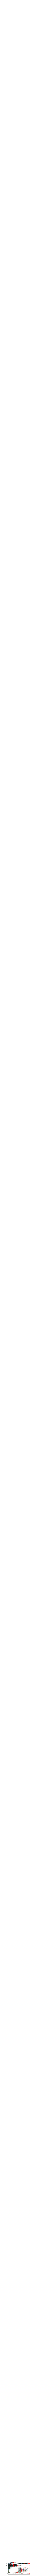

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.71
backpack 62.36
sandwich 61.01
bicycle 65.95
car 60.63
bus 60.85
bench 65.25
bear 65.18
backpack 66.62
handbag 62.2
suitcase 64.2
baseball bat 65.61
surfboard 67.08
spoon 65.78
sandwich 67.08
pizza 64.6
mouse 64.55
remote 65.16
keyboard 60.54
microwave 63.13
book 63.73
handbag 62.91
baseball bat 62.87
surfboard 63.75
cup 61.73
spoon 62.13
bicycle 65.36
car 62.35
bus 64.59
truck 60.61
bench 65.36
bear 63.05
backpack 66.04
handbag 62.34
suitcase 64.88
baseball bat 63.37
surfboard 66.19
spoon 63.7
sandwich 65.57
pizza 65.58
cake 60.58
mouse 63.07
remote 61.59
keyboard 64.91
microwave 61.18
book 64.58
bus 65.63
truck 60.24
traffic light 65.82
parking meter 66.0
bench 63.03
horse 61.75
elephant 63.76
backpack 65.89
tie 63.67
suitcase 63.49
skis 64.37
bowl 65.74
apple 65.23
sandwich 60.87
diningtable 60.28
toilet 65.76
tvmonitor 62.21
clock 62.48
teddy bear 61.54
toothbrush 66.38
bicycle 62.09
car 61.0
bus 62.84
bench 63.01
bea

tvmonitor 82.19
cell phone 62.81
microwave 61.32
book 75.03
teddy bear 82.18
toothbrush 82.17
car 82.34
aeroplane 81.97
bus 79.33
traffic light 79.02
parking meter 82.51
bench 80.12
dog 78.33
sheep 78.84
cow 82.11
elephant 82.42
zebra 81.61
giraffe 73.7
backpack 82.45
handbag 66.96
tie 81.74
suitcase 82.51
skis 82.41
snowboard 68.57
sports ball 80.98
kite 82.45
baseball bat 63.18
bottle 82.01
bowl 82.29
carrot 79.63
hot dog 80.32
chair 63.65
pottedplant 76.03
bed 80.67
diningtable 80.86
toilet 79.98
tvmonitor 82.51
cell phone 62.27
microwave 64.0
book 73.35
teddy bear 82.49
toothbrush 82.48
person 61.51
car 83.46
aeroplane 82.94
bus 80.49
traffic light 80.84
parking meter 83.62
bench 80.93
dog 78.62
sheep 79.71
cow 83.25
elephant 83.52
zebra 82.56
giraffe 74.69
backpack 83.56
handbag 67.37
tie 82.77
suitcase 83.62
skis 83.55
snowboard 68.9
sports ball 82.13
kite 83.57
baseball bat 62.22
bottle 83.16
bowl 83.37
carrot 80.2
hot dog 81.17
chair 61.8
pottedplant 76.81
bed 81.92
diningtable

parking meter 71.79
bench 68.91
dog 65.93
sheep 69.48
cow 71.5
elephant 71.72
zebra 69.93
giraffe 62.82
backpack 71.67
tie 70.78
suitcase 71.79
skis 71.64
sports ball 70.08
kite 71.75
bottle 71.37
bowl 71.48
carrot 69.32
hot dog 70.01
pottedplant 66.24
bed 70.62
diningtable 70.75
toilet 68.24
tvmonitor 71.79
book 62.4
teddy bear 71.78
toothbrush 71.76
car 77.66
aeroplane 74.18
bus 67.13
traffic light 77.43
parking meter 78.12
bench 76.63
sheep 77.67
cow 76.77
elephant 76.41
bear 77.35
giraffe 72.91
backpack 77.14
tie 75.61
suitcase 78.11
skis 77.62
snowboard 71.83
kite 77.33
bottle 77.12
bowl 77.55
carrot 74.36
hot dog 74.01
bed 75.08
toilet 73.93
tvmonitor 77.64
remote 75.86
book 72.7
teddy bear 78.08
toothbrush 77.85
car 64.85
aeroplane 64.74
bus 63.13
traffic light 65.03
parking meter 65.39
bench 64.54
dog 60.49
sheep 62.48
cow 65.2
elephant 64.89
backpack 65.13
tie 63.73
suitcase 65.39
skis 65.26
kite 65.3
bottle 65.15
bowl 65.22
carrot 63.83
hot dog 63.31
diningtable 61.92
toilet 

sink 60.22
cup 61.12
spoon 60.43
carrot 62.2
donut 60.16
cell phone 61.4
sink 62.88
snowboard 60.04
cup 61.12
tvmonitor 61.23
cell phone 61.66
sink 64.01
carrot 60.16
sink 60.39
cup 60.31
carrot 61.36
cell phone 60.69
sink 62.1
cup 60.84
tvmonitor 60.83
cell phone 61.26
sink 63.54
carrot 61.54
cell phone 60.88
sink 61.79
book 60.2
cup 61.66
spoon 61.14
carrot 62.79
donut 60.53
cell phone 61.99
sink 63.48
book 60.66
cup 60.79
tvmonitor 60.68
cell phone 60.95
sink 63.19
carrot 61.52
cell phone 60.81
sink 61.67
book 60.09
cup 60.63
carrot 61.52
cell phone 60.76
sink 62.18
snowboard 60.18
cup 61.66
tvmonitor 62.0
cell phone 62.12
sink 64.42
carrot 61.1
cell phone 60.44
sink 61.22
cup 62.16
spoon 61.9
carrot 63.26
donut 60.81
cell phone 62.4
sink 63.76
book 60.64
cell phone 60.12
sink 62.3
car 60.94
snowboard 61.02
spoon 61.64
carrot 62.61
cake 61.95
cell phone 62.39
sink 62.81
book 61.47
car 61.25
dog 60.73
snowboard 60.59
spoon 61.79
carrot 63.37
donut 60.67
cake 61.83
cell phone 62.61
si

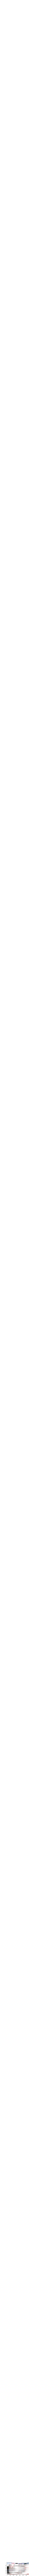

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.0
backpack 62.76
sandwich 61.39
microwave 60.32
bicycle 66.04
car 61.21
bus 60.93
bench 65.4
bear 65.28
backpack 66.88
handbag 62.04
suitcase 64.21
baseball bat 65.76
surfboard 67.33
spoon 65.92
sandwich 67.33
pizza 64.62
mouse 64.6
remote 65.34
keyboard 60.9
microwave 63.42
book 63.97
handbag 61.93
baseball bat 61.9
surfboard 62.84
cup 60.75
spoon 61.33
bicycle 64.69
car 61.55
bus 64.05
truck 60.03
bench 64.72
bear 62.53
backpack 65.47
handbag 61.66
suitcase 64.26
baseball bat 62.71
surfboard 65.6
spoon 63.12
sandwich 65.02
pizza 64.94
cake 60.37
mouse 62.27
remote 60.83
keyboard 64.34
microwave 60.34
book 64.02
bus 67.3
truck 62.02
traffic light 67.59
parking meter 67.78
bench 64.9
horse 63.27
elephant 65.33
backpack 67.75
tie 65.33
suitcase 65.05
skis 66.06
bowl 67.48
apple 66.9
sandwich 62.24
pottedplant 61.61
diningtable 61.72
toilet 67.49
tvmonitor 63.7
clock 64.12
teddy bear 62.95
toothbrush 68.17
bus 60.61
bench 60.

pottedplant 76.16
bed 81.27
diningtable 80.95
toilet 80.47
tvmonitor 82.97
cell phone 64.31
microwave 62.51
refrigerator 61.54
book 73.16
teddy bear 82.96
toothbrush 82.94
person 60.66
car 76.37
aeroplane 75.95
bus 74.16
traffic light 74.84
parking meter 76.48
bench 73.47
dog 71.64
sheep 72.97
cow 76.17
elephant 76.41
zebra 75.21
giraffe 67.9
backpack 76.36
handbag 60.29
tie 75.48
suitcase 76.48
skis 76.35
sports ball 74.4
kite 76.43
bottle 76.04
bowl 76.23
carrot 73.22
hot dog 74.51
pottedplant 70.97
bed 75.15
diningtable 75.08
toilet 74.01
tvmonitor 76.48
cell phone 60.29
book 66.94
teddy bear 76.46
toothbrush 76.45
car 80.59
aeroplane 77.0
bus 71.3
traffic light 80.53
parking meter 81.19
bench 79.7
sheep 80.7
cow 79.78
elephant 79.5
bear 80.1
zebra 61.84
giraffe 75.65
backpack 80.15
tie 78.9
suitcase 81.18
skis 80.76
snowboard 74.7
sports ball 62.93
kite 80.18
bottle 80.09
bowl 80.67
carrot 77.93
hot dog 77.48
bed 77.78
toilet 76.71
tvmonitor 80.72
remote 78.63
book 74.38
teddy bear

book 69.47
teddy bear 77.11
toothbrush 77.1
car 77.53
aeroplane 77.29
bus 73.64
traffic light 74.4
parking meter 77.73
bench 75.42
dog 72.64
sheep 74.96
cow 77.39
elephant 77.64
zebra 76.36
giraffe 69.33
backpack 77.65
handbag 62.82
tie 76.89
suitcase 77.73
skis 77.65
snowboard 62.43
sports ball 76.3
kite 77.68
bottle 77.27
bowl 77.43
carrot 74.81
hot dog 75.32
chair 60.11
pottedplant 70.65
bed 76.03
diningtable 76.26
toilet 74.27
tvmonitor 77.72
cell phone 60.83
book 70.44
teddy bear 77.71
toothbrush 77.7
car 76.08
aeroplane 75.78
bus 71.81
traffic light 73.37
parking meter 76.28
bench 73.62
dog 70.49
sheep 73.11
cow 75.99
elephant 76.18
zebra 74.6
giraffe 67.13
backpack 76.21
handbag 61.69
tie 75.41
suitcase 76.28
skis 76.21
sports ball 75.07
kite 76.24
bottle 75.86
bowl 75.98
carrot 73.04
hot dog 73.92
pottedplant 69.16
bed 74.68
diningtable 74.93
toilet 72.65
tvmonitor 76.27
book 68.69
teddy bear 76.26
toothbrush 76.25
car 70.28
aeroplane 69.95
bus 67.2
traffic light 68.48
parking 

sink 62.89
book 60.19
knife 60.46
carrot 62.7
cake 61.39
cell phone 62.16
sink 61.08
umbrella 62.25
cup 63.78
knife 62.64
spoon 61.78
carrot 63.03
donut 61.17
cake 60.44
cell phone 63.58
sink 63.04
skateboard 63.4
carrot 64.01
donut 62.89
cake 66.15
tvmonitor 63.28
cell phone 65.05
sink 63.93
book 60.45
skateboard 62.46
carrot 60.67
donut 62.08
cake 62.54
tvmonitor 64.41
cell phone 64.92
sink 63.46
dog 60.49
skateboard 65.3
carrot 62.99
donut 64.16
cake 64.7
tvmonitor 65.73
cell phone 65.89
sink 65.13
skateboard 64.59
carrot 62.74
donut 64.39
cake 64.37
tvmonitor 65.42
cell phone 64.99
sink 65.12
skateboard 63.41
carrot 61.23
donut 63.35
cake 62.72
tvmonitor 63.72
cell phone 64.12
sink 64.1
clock 60.0
skateboard 62.86
carrot 61.08
donut 63.0
cake 62.51
tvmonitor 63.42
cell phone 63.88
sink 64.09
toaster 60.44
clock 60.53
skateboard 62.7
carrot 61.16
donut 62.98
cake 62.58
tvmonitor 63.35
cell phone 63.71
sink 63.97
skateboard 62.49
carrot 60.7
donut 62.99
cake 62.53
tvmonitor 63.21
cel

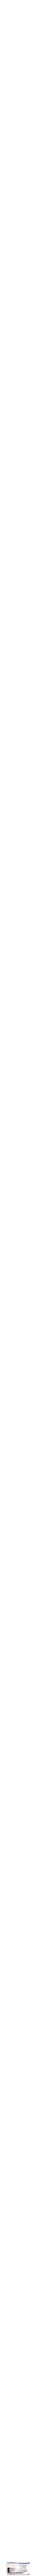

In [18]:
j=0
for i in range(len(glob.glob('/home/zahid/Downloads/objectDetection ssd/data/testing_images/*.jpg'))):
    if j<=10:
        predict_bb_image(glob.glob('/home/zahid/Downloads/objectDetection ssd/data/testing_images/*.jpg')[i])
        j+=1
    else:
        break

<h1><span class="label label-default" style="background-color:black;border-radius:100px 100px; font-weight: bold; font-family:Garamond; font-size:20px; color:#03e8fc; padding:10px">Train Set prediction</span></h1><br>

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.22
backpack 62.94
sandwich 61.51
microwave 60.43
book 60.12
bicycle 66.18
car 61.05
bus 60.92
bench 65.62
bear 65.34
backpack 66.94
handbag 62.38
suitcase 64.25
baseball bat 65.9
surfboard 67.41
spoon 66.01
sandwich 67.4
pizza 64.73
mouse 64.68
remote 65.48
keyboard 60.89
microwave 63.49
book 63.91
handbag 62.71
baseball bat 62.64
surfboard 63.62
cup 61.48
spoon 62.03
bicycle 65.16
car 61.9
bus 64.49
truck 60.37
bench 65.16
bear 63.02
backpack 65.88
handbag 61.96
suitcase 64.72
baseball bat 63.1
surfboard 66.02
spoon 63.48
sandwich 65.41
pizza 65.4
cake 60.66
mouse 62.73
remote 61.24
keyboard 64.76
microwave 60.77
book 64.41
bus 67.34
truck 62.08
traffic light 67.68
parking meter 67.84
bench 65.05
horse 63.47
elephant 65.41
backpack 67.82
tie 65.42
suitcase 65.11
skis 66.07
bowl 67.58
apple 66.98
sandwich 62.75
pottedplant 61.77
diningtable 61.7
toilet 67.53
tvmonitor 63.95
clock 64.02
teddy bear 62.84
toothbrush 68.27
bus 

backpack 82.32
handbag 66.33
tie 81.63
suitcase 82.36
skis 82.27
snowboard 66.05
sports ball 80.79
kite 82.3
baseball bat 62.32
bottle 81.89
bowl 82.13
carrot 78.8
hot dog 79.95
chair 65.48
pottedplant 75.95
bed 80.68
diningtable 80.75
toilet 79.28
tvmonitor 82.36
cell phone 64.54
microwave 63.19
book 75.13
teddy bear 82.35
toothbrush 82.34
car 83.32
aeroplane 82.74
bus 80.68
traffic light 80.22
parking meter 83.47
bench 80.57
dog 78.68
sheep 78.79
cow 83.13
elephant 83.35
zebra 82.36
giraffe 74.96
backpack 83.41
handbag 68.24
tie 82.61
suitcase 83.46
skis 83.39
snowboard 69.22
sports ball 81.91
kite 83.42
baseball bat 63.85
bottle 83.06
bowl 83.19
carrot 80.14
hot dog 81.01
chair 62.2
pottedplant 76.29
bed 81.67
diningtable 81.74
toilet 81.05
tvmonitor 83.46
cell phone 65.17
microwave 62.07
book 74.5
teddy bear 83.45
toothbrush 83.43
car 74.41
aeroplane 73.9
bus 72.52
traffic light 72.68
parking meter 74.54
bench 72.09
dog 70.01
sheep 70.97
cow 74.29
elephant 74.47
zebra 73.33
giraffe

parking meter 78.22
bench 76.72
sheep 77.76
cow 76.84
elephant 76.54
bear 77.46
giraffe 73.29
backpack 77.18
tie 75.74
suitcase 78.21
skis 77.69
snowboard 72.07
sports ball 60.91
kite 77.4
bottle 77.12
bowl 77.64
carrot 74.54
hot dog 74.15
bed 75.19
toilet 74.08
tvmonitor 77.74
remote 75.96
book 72.44
teddy bear 78.17
toothbrush 77.92
car 62.71
aeroplane 62.59
bus 61.31
traffic light 62.91
parking meter 63.25
bench 62.4
sheep 60.44
cow 63.04
elephant 62.79
backpack 62.94
tie 61.56
suitcase 63.25
skis 63.13
kite 63.15
bottle 63.0
bowl 63.09
carrot 61.41
hot dog 61.21
toilet 61.95
tvmonitor 63.23
teddy bear 63.24
toothbrush 63.2
car 69.31
aeroplane 69.24
bus 68.29
traffic light 65.31
parking meter 69.56
bench 67.47
dog 65.02
sheep 66.49
cow 69.23
elephant 69.35
zebra 68.0
giraffe 62.81
backpack 69.42
tie 68.84
suitcase 69.56
skis 69.5
sports ball 67.75
kite 69.52
bottle 69.29
bowl 69.34
carrot 67.52
hot dog 67.44
pottedplant 63.32
bed 67.55
diningtable 67.17
toilet 66.81
tvmonitor 69.56


cup 63.19
spoon 62.42
carrot 64.25
donut 61.61
cell phone 63.64
sink 64.92
book 61.64
snowboard 60.29
cup 61.74
tvmonitor 62.08
cell phone 62.08
sink 64.59
car 60.29
snowboard 60.16
cup 62.66
spoon 62.24
carrot 63.81
donut 61.2
cell phone 62.99
sink 64.21
book 61.14
cup 60.55
tvmonitor 60.8
cell phone 60.92
sink 63.26
spoon 60.39
carrot 61.42
cake 60.79
cell phone 61.2
sink 61.59
book 60.25
car 63.17
dog 62.65
snowboard 62.08
cup 60.31
knife 60.9
spoon 63.79
bowl 60.03
carrot 65.19
donut 62.51
cake 63.65
cell phone 64.46
sink 65.42
book 63.7
car 61.81
snowboard 60.4
cup 63.42
knife 60.74
spoon 63.56
carrot 64.46
donut 62.09
cake 60.39
cell phone 64.04
sink 65.26
book 61.0
car 60.7
spoon 61.66
carrot 62.46
donut 60.86
cake 62.02
cell phone 62.3
sink 62.58
book 60.08
car 60.78
spoon 61.29
carrot 62.45
donut 60.72
cake 61.63
cell phone 62.2
sink 62.59
car 64.13
dog 60.16
umbrella 62.43
snowboard 60.93
cup 65.08
knife 64.11
spoon 66.91
carrot 67.14
donut 65.64
cake 63.72
tvmonitor 63.3
cel

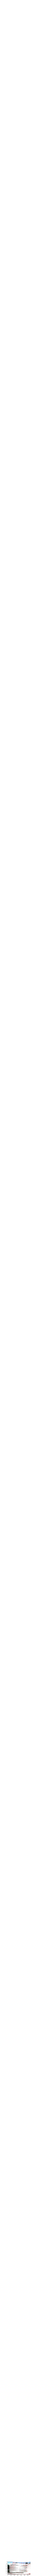

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.01
backpack 62.75
sandwich 61.3
microwave 60.2
bicycle 66.0
car 60.77
bus 60.78
bench 65.41
bear 65.17
backpack 66.73
handbag 62.2
suitcase 64.04
baseball bat 65.69
surfboard 67.23
spoon 65.81
sandwich 67.21
pizza 64.56
mouse 64.44
remote 65.18
keyboard 60.85
microwave 63.2
book 63.72
handbag 62.62
baseball bat 62.62
surfboard 63.55
cup 61.43
spoon 62.03
bicycle 65.41
car 62.26
bus 64.71
truck 60.3
bench 65.41
bear 63.06
backpack 66.16
handbag 62.18
suitcase 64.87
baseball bat 63.41
surfboard 66.3
spoon 63.78
sandwich 65.66
pizza 65.68
cake 60.84
mouse 63.07
remote 61.5
keyboard 65.01
microwave 61.02
book 64.62
bus 67.14
truck 61.33
traffic light 67.43
parking meter 67.61
bench 64.6
horse 63.31
elephant 65.14
backpack 67.6
tie 65.14
suitcase 64.88
skis 65.86
bowl 67.31
apple 66.66
sandwich 61.87
pottedplant 61.55
diningtable 61.65
toilet 67.3
tvmonitor 63.62
clock 63.8
teddy bear 62.71
toothbrush 68.0
bicycle 61.52
car 60.4

tie 79.96
suitcase 80.71
skis 80.65
snowboard 64.05
sports ball 79.19
kite 80.65
baseball bat 61.46
bottle 80.27
bowl 80.5
carrot 76.89
hot dog 78.21
chair 60.33
pottedplant 75.01
bed 79.1
diningtable 78.47
toilet 78.11
tvmonitor 80.71
cell phone 63.35
microwave 61.38
book 72.33
clock 60.02
teddy bear 80.7
toothbrush 80.69
car 81.85
aeroplane 81.39
bus 79.31
traffic light 78.8
parking meter 82.03
bench 79.25
dog 77.6
sheep 78.25
cow 81.7
elephant 81.95
zebra 80.94
giraffe 72.32
backpack 81.98
handbag 65.68
tie 81.12
suitcase 82.03
skis 81.95
snowboard 66.47
sports ball 80.54
kite 81.96
baseball bat 63.7
bottle 81.59
bowl 81.74
carrot 78.17
hot dog 79.5
chair 65.04
pottedplant 76.38
bed 80.21
diningtable 80.18
toilet 79.8
tvmonitor 82.03
cell phone 65.17
microwave 60.43
book 73.13
teddy bear 82.01
toothbrush 82.01
car 81.58
aeroplane 81.13
bus 78.65
traffic light 78.39
parking meter 81.74
bench 79.34
dog 77.34
sheep 77.37
cow 81.42
elephant 81.66
zebra 80.68
giraffe 73.12
backpack 81.69

kite 77.15
bottle 76.82
bowl 76.96
carrot 73.95
hot dog 74.85
pottedplant 70.92
bed 75.81
diningtable 75.73
toilet 73.53
tvmonitor 77.19
cell phone 61.29
book 70.53
teddy bear 77.18
toothbrush 77.17
person 60.77
car 73.03
aeroplane 72.62
bus 70.06
traffic light 71.42
parking meter 73.15
bench 69.82
dog 66.11
sheep 71.02
cow 72.92
elephant 73.1
zebra 71.03
giraffe 63.75
backpack 73.03
tie 72.28
suitcase 73.15
skis 73.02
sports ball 71.51
kite 73.12
bottle 72.76
bowl 72.87
carrot 70.36
hot dog 71.32
pottedplant 67.44
bed 71.96
diningtable 71.86
toilet 69.95
tvmonitor 73.15
book 63.63
teddy bear 73.14
toothbrush 73.12
car 78.12
aeroplane 75.34
bus 68.18
traffic light 77.93
parking meter 78.63
bench 77.08
sheep 78.16
cow 77.29
elephant 76.89
bear 77.83
zebra 60.13
giraffe 73.16
backpack 77.7
tie 76.12
suitcase 78.63
skis 78.1
snowboard 72.28
sports ball 60.08
kite 77.88
bottle 77.6
bowl 78.08
carrot 74.97
hot dog 74.97
bed 75.87
toilet 74.4
tvmonitor 78.17
remote 76.42
book 73.24
teddy bea

book 60.27
cup 61.39
tvmonitor 61.44
cell phone 61.95
sink 64.2
car 61.86
dog 61.64
snowboard 61.28
spoon 61.24
carrot 63.93
donut 60.19
cake 62.23
cell phone 63.21
sink 64.16
book 62.5
cup 61.19
spoon 60.65
carrot 62.25
cell phone 61.56
sink 62.84
book 60.14
snowboard 60.11
cup 61.77
tvmonitor 61.47
cell phone 62.01
sink 64.31
car 60.67
dog 60.24
snowboard 60.28
spoon 60.29
carrot 62.55
cake 61.0
cell phone 61.82
sink 62.76
book 60.9
car 60.65
snowboard 60.14
cup 62.69
spoon 62.13
carrot 63.63
donut 60.98
cell phone 62.89
sink 64.29
book 61.13
snowboard 60.59
cup 61.4
tvmonitor 61.97
cell phone 62.03
sink 64.5
carrot 60.23
sink 60.35
cup 62.32
spoon 61.76
carrot 63.28
donut 60.95
cell phone 62.57
sink 63.8
book 61.23
cell phone 60.01
sink 62.35
carrot 60.79
cake 60.21
cell phone 60.65
sink 60.98
car 61.77
dog 61.31
snowboard 60.55
spoon 62.29
carrot 63.84
donut 60.94
cake 62.21
cell phone 63.13
sink 64.03
book 62.4
car 62.25
snowboard 60.84
cup 64.05
knife 60.97
spoon 64.11
carrot 65.

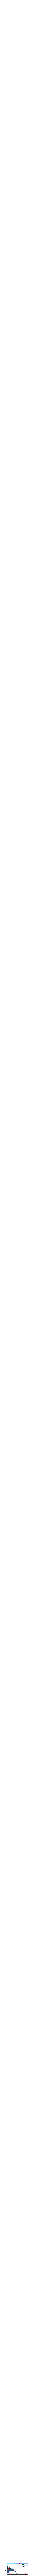

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.96
backpack 63.7
spoon 60.06
sandwich 62.31
microwave 61.23
book 60.83
bicycle 67.11
car 61.79
bus 61.82
bench 66.51
bear 66.37
backpack 67.9
handbag 63.24
tie 60.68
suitcase 65.15
baseball bat 66.74
surfboard 68.37
spoon 67.0
bowl 60.48
sandwich 68.35
pizza 65.67
mouse 65.76
remote 66.3
keyboard 61.78
microwave 64.38
book 64.92
handbag 62.68
baseball bat 62.68
surfboard 63.62
cup 61.54
spoon 62.1
bicycle 64.81
car 62.01
bus 64.13
truck 60.23
bench 64.75
bear 62.57
backpack 65.52
handbag 61.72
suitcase 64.3
baseball bat 62.78
surfboard 65.67
spoon 63.3
sandwich 65.1
pizza 65.05
cake 60.5
mouse 62.55
remote 61.03
keyboard 64.39
microwave 60.62
book 64.12
bus 66.69
truck 61.86
traffic light 66.99
parking meter 67.18
bench 64.25
horse 62.78
elephant 64.88
backpack 67.17
tie 64.57
suitcase 64.48
skis 65.38
bowl 66.9
apple 66.36
sandwich 61.8
pottedplant 60.79
diningtable 61.3
toilet 66.92
tvmonitor 63.59
clock 63.73
teddy bear 

toilet 80.05
tvmonitor 82.52
cell phone 63.0
microwave 61.34
book 75.03
clock 61.79
teddy bear 82.51
toothbrush 82.5
car 81.46
aeroplane 81.1
bus 79.3
traffic light 78.42
parking meter 81.64
bench 79.01
dog 76.96
sheep 77.57
cow 81.25
elephant 81.55
zebra 80.85
giraffe 73.62
backpack 81.57
handbag 66.34
tie 80.79
suitcase 81.64
skis 81.56
snowboard 65.5
sports ball 80.07
kite 81.58
baseball bat 63.29
bottle 81.21
bowl 81.45
carrot 77.57
hot dog 79.43
chair 60.4
pottedplant 75.97
bed 80.12
diningtable 79.44
toilet 79.34
tvmonitor 81.64
cell phone 62.67
microwave 60.77
book 73.04
teddy bear 81.63
toothbrush 81.62
car 81.96
aeroplane 81.52
bus 79.03
traffic light 79.01
parking meter 82.11
bench 79.61
dog 77.61
sheep 78.74
cow 81.77
elephant 82.03
zebra 81.16
giraffe 74.21
backpack 82.06
handbag 65.56
tie 81.35
suitcase 82.11
skis 82.02
snowboard 66.93
sports ball 80.47
kite 82.05
baseball bat 64.91
bottle 81.66
bowl 81.9
carrot 78.43
hot dog 79.49
chair 63.0
pottedplant 76.56
bed 80.46
di

diningtable 75.66
toilet 73.57
tvmonitor 76.96
cell phone 60.26
book 69.46
teddy bear 76.95
toothbrush 76.93
car 70.22
aeroplane 69.89
bus 66.91
traffic light 68.75
parking meter 70.33
bench 67.28
dog 63.89
sheep 68.56
cow 70.1
elephant 70.27
zebra 68.09
giraffe 61.12
backpack 70.21
tie 69.48
suitcase 70.33
skis 70.2
sports ball 68.82
kite 70.29
bottle 69.85
bowl 70.05
carrot 67.58
hot dog 68.41
pottedplant 65.74
bed 69.28
diningtable 69.45
toilet 67.33
tvmonitor 70.32
book 61.78
teddy bear 70.31
toothbrush 70.29
car 77.1
aeroplane 73.95
bus 67.64
traffic light 76.86
parking meter 77.6
bench 76.04
sheep 77.14
cow 76.26
elephant 75.88
bear 76.71
giraffe 72.38
backpack 76.6
tie 75.14
suitcase 77.59
skis 77.07
snowboard 71.76
kite 76.8
bottle 76.57
bowl 77.01
carrot 74.09
hot dog 73.4
bed 74.35
toilet 73.44
tvmonitor 77.13
remote 75.22
book 71.91
teddy bear 77.55
toothbrush 77.29
car 66.72
aeroplane 66.64
bus 64.97
traffic light 66.91
parking meter 67.28
bench 66.36
dog 62.4
sheep 64.3
co

donut 60.6
cake 62.37
cell phone 63.02
sink 62.15
umbrella 64.09
cup 65.86
knife 64.68
spoon 63.97
carrot 65.21
donut 63.41
cake 62.3
tvmonitor 61.7
cell phone 65.54
microwave 60.21
sink 65.2
skateboard 63.57
carrot 63.7
donut 62.88
cake 66.27
tvmonitor 62.83
cell phone 65.03
sink 63.33
book 60.24
dog 60.41
skateboard 63.13
carrot 61.4
donut 62.92
cake 63.31
tvmonitor 65.39
cell phone 66.02
sink 64.35
skateboard 65.23
carrot 62.84
donut 64.26
cake 64.96
tvmonitor 65.66
cell phone 66.11
sink 65.37
dog 60.04
skateboard 64.09
carrot 62.56
donut 64.5
cake 64.14
tvmonitor 65.11
cell phone 65.18
sink 64.99
skateboard 62.0
carrot 60.27
donut 62.03
cake 61.54
tvmonitor 62.42
cell phone 62.88
sink 63.05
skateboard 63.17
carrot 61.53
donut 63.45
cake 62.91
tvmonitor 63.91
cell phone 64.15
sink 64.46
clock 60.01
skateboard 62.04
carrot 60.68
donut 62.61
cake 61.96
tvmonitor 62.87
cell phone 63.07
sink 63.39
toaster 60.14
clock 60.12
skateboard 62.92
carrot 61.07
donut 63.1
cake 62.66
tvmonitor 63

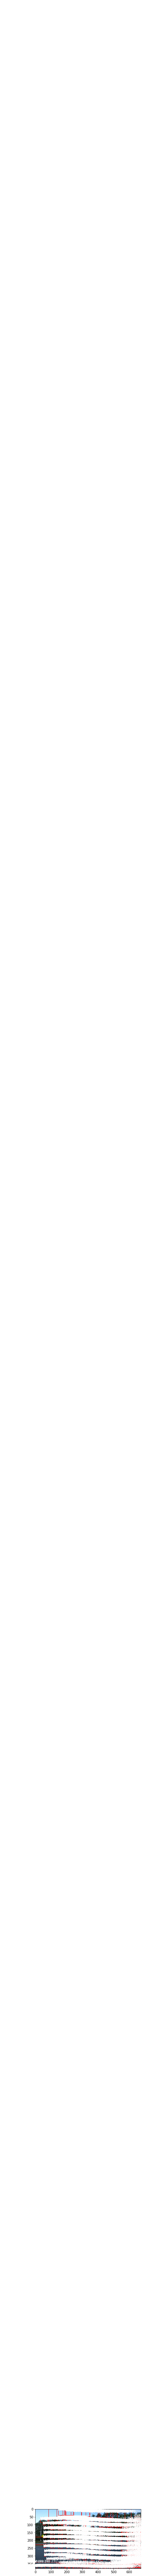

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.63
backpack 62.39
sandwich 60.97
bicycle 66.21
car 61.2
bus 61.14
bench 65.68
bear 65.54
backpack 67.04
handbag 62.35
suitcase 64.45
baseball bat 65.98
surfboard 67.49
spoon 66.12
sandwich 67.51
pizza 64.79
mouse 64.83
remote 65.43
keyboard 61.15
microwave 63.54
book 64.15
handbag 63.35
baseball bat 63.28
surfboard 64.28
cup 62.07
spoon 62.65
keyboard 60.47
bicycle 65.42
car 62.16
bus 64.85
truck 60.48
bench 65.59
bear 63.39
backpack 66.23
handbag 62.35
suitcase 65.08
baseball bat 63.49
surfboard 66.36
spoon 64.03
sandwich 65.79
pizza 65.7
cake 61.11
mouse 63.22
remote 61.99
keyboard 65.08
microwave 61.33
book 64.68
bus 66.49
truck 61.18
traffic light 66.78
parking meter 66.9
bench 64.14
horse 62.77
elephant 64.53
backpack 66.83
tie 64.51
suitcase 64.27
skis 65.18
bowl 66.63
apple 66.02
sandwich 61.54
pottedplant 60.58
diningtable 60.98
toilet 66.62
tvmonitor 63.36
clock 63.31
teddy bear 62.3
toothbrush 67.29
bicycle 61.07


parking meter 81.4
bench 78.56
dog 76.43
sheep 77.56
cow 81.08
elephant 81.31
zebra 80.42
giraffe 73.36
backpack 81.34
handbag 64.5
tie 80.54
suitcase 81.4
skis 81.31
snowboard 67.86
sports ball 79.54
kite 81.35
baseball bat 61.74
bottle 80.97
bowl 81.21
carrot 78.12
hot dog 78.92
chair 65.22
pottedplant 75.58
bed 79.61
diningtable 79.79
toilet 78.68
tvmonitor 81.4
cell phone 65.45
book 72.72
teddy bear 81.39
toothbrush 81.38
person 60.5
car 84.58
aeroplane 84.08
bus 81.64
traffic light 81.99
parking meter 84.75
bench 81.8
dog 80.11
sheep 80.14
cow 84.4
elephant 84.63
zebra 83.59
giraffe 75.99
backpack 84.68
handbag 69.51
tie 83.98
suitcase 84.75
skis 84.65
snowboard 72.02
sports ball 83.17
kite 84.68
baseball bat 65.28
bottle 84.26
bowl 84.49
carrot 81.5
hot dog 81.81
chair 63.28
pottedplant 78.31
bed 82.98
diningtable 83.0
toilet 81.76
tvmonitor 84.75
cell phone 66.83
microwave 66.82
refrigerator 60.61
book 75.77
clock 61.23
teddy bear 84.73
toothbrush 84.72
car 74.14
aeroplane 73.7


hot dog 73.39
pottedplant 70.29
bed 74.13
diningtable 74.26
toilet 72.29
tvmonitor 75.81
cell phone 60.45
book 69.32
teddy bear 75.8
toothbrush 75.79
car 75.76
aeroplane 75.5
bus 71.99
traffic light 72.64
parking meter 75.95
bench 73.56
dog 71.6
sheep 73.56
cow 75.64
elephant 75.87
zebra 74.48
giraffe 67.32
backpack 75.89
handbag 62.46
tie 75.22
suitcase 75.95
skis 75.87
sports ball 74.55
kite 75.91
bottle 75.53
bowl 75.72
carrot 73.16
hot dog 73.66
pottedplant 69.89
bed 74.2
diningtable 74.5
toilet 72.37
tvmonitor 75.95
book 68.96
teddy bear 75.94
toothbrush 75.93
car 75.8
aeroplane 75.49
bus 72.04
traffic light 72.73
parking meter 75.98
bench 73.76
dog 71.16
sheep 73.4
cow 75.68
elephant 75.9
zebra 74.52
giraffe 67.26
backpack 75.92
handbag 63.03
tie 75.2
suitcase 75.98
skis 75.9
sports ball 74.53
kite 75.94
bottle 75.54
bowl 75.72
carrot 72.95
hot dog 73.62
pottedplant 68.94
bed 74.27
diningtable 74.58
toilet 72.35
tvmonitor 75.98
book 69.47
teddy bear 75.97
toothbrush 75.96
car 75.

carrot 61.6
donut 63.31
cake 62.77
tvmonitor 63.75
cell phone 64.14
sink 64.37
skateboard 62.46
carrot 60.72
donut 62.66
cake 62.07
tvmonitor 62.97
cell phone 63.33
sink 63.67
skateboard 62.35
carrot 61.03
donut 62.64
cake 62.02
tvmonitor 62.86
cell phone 63.46
sink 63.7
toaster 60.82
clock 60.89
skateboard 62.52
carrot 61.11
donut 62.87
cake 62.41
tvmonitor 63.1
cell phone 63.59
sink 63.93
skateboard 62.6
carrot 61.07
donut 62.89
cake 62.35
tvmonitor 63.2
cell phone 63.58
sink 63.85
skateboard 62.84
carrot 61.51
donut 63.15
cake 62.62
tvmonitor 63.53
cell phone 63.73
sink 64.09
toaster 60.62
clock 60.69
skateboard 62.72
carrot 61.44
donut 63.21
cake 62.5
tvmonitor 63.45
cell phone 63.83
sink 64.12
skateboard 63.25
carrot 62.12
donut 63.89
cake 63.28
tvmonitor 63.88
cell phone 64.52
sink 65.0
toaster 60.42
clock 60.6
skateboard 63.45
carrot 61.99
donut 63.74
cake 63.37
tvmonitor 64.18
cell phone 64.9
sink 65.54
toaster 62.43
clock 62.53
skateboard 63.21
carrot 61.07
donut 62.35
cake 62

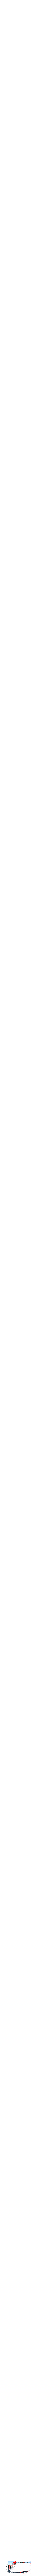

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.7
backpack 62.4
sandwich 60.97
bicycle 66.26
car 61.74
bus 61.56
bench 65.71
bear 65.66
backpack 67.0
handbag 62.75
suitcase 64.43
baseball bat 65.95
surfboard 67.49
spoon 65.97
sandwich 67.44
pizza 64.96
mouse 65.13
remote 65.37
keyboard 61.24
microwave 64.05
book 63.97
handbag 60.93
baseball bat 60.76
surfboard 61.75
spoon 60.28
bicycle 66.0
car 63.52
bus 65.44
truck 61.33
bench 65.93
bear 63.97
backpack 66.63
handbag 62.92
suitcase 65.43
baseball bat 63.89
surfboard 66.8
spoon 64.77
sandwich 66.18
pizza 66.13
cake 61.48
mouse 63.64
remote 62.1
keyboard 65.68
microwave 61.63
book 65.2
bus 65.43
traffic light 65.64
parking meter 65.84
bench 62.86
horse 61.34
elephant 63.55
backpack 65.88
tie 63.76
suitcase 63.36
skis 64.3
bowl 65.53
apple 65.05
sandwich 60.31
toilet 65.63
tvmonitor 62.31
clock 62.48
teddy bear 61.1
toothbrush 66.24
bicycle 61.54
car 60.71
bus 62.51
bench 62.69
bear 60.15
backpack 63.04
suitcase 62.13
baseb

baseball bat 66.13
bottle 83.21
bowl 83.38
carrot 80.09
hot dog 80.96
chair 65.34
pottedplant 78.34
bed 81.75
diningtable 81.58
toilet 80.6
tvmonitor 83.58
cell phone 67.04
microwave 63.32
book 75.25
teddy bear 83.56
toothbrush 83.55
car 80.62
aeroplane 80.23
bus 77.86
traffic light 77.45
parking meter 80.78
bench 78.21
dog 76.27
sheep 77.4
cow 80.41
elephant 80.7
zebra 79.92
giraffe 73.93
backpack 80.73
handbag 64.09
tie 80.04
suitcase 80.78
skis 80.7
snowboard 67.5
sports ball 79.31
kite 80.72
baseball bat 64.7
bottle 80.37
bowl 80.54
carrot 76.93
hot dog 78.55
chair 63.09
pottedplant 74.8
bed 79.28
diningtable 79.16
toilet 77.95
tvmonitor 80.78
cell phone 63.54
microwave 60.61
book 71.74
teddy bear 80.76
toothbrush 80.75
car 82.08
aeroplane 81.7
bus 79.56
traffic light 79.21
parking meter 82.24
bench 79.06
dog 77.45
sheep 78.09
cow 81.89
elephant 82.12
zebra 81.26
giraffe 74.62
backpack 82.18
handbag 66.26
tie 81.38
suitcase 82.24
skis 82.16
snowboard 70.84
sports ball 80.77
kite 82

bed 68.97
diningtable 68.72
toilet 68.42
tvmonitor 71.22
book 65.97
teddy bear 71.21
toothbrush 71.2
car 74.65
aeroplane 74.4
bus 71.99
traffic light 71.42
parking meter 74.85
bench 72.26
dog 69.66
sheep 72.37
cow 74.53
elephant 74.72
zebra 73.65
giraffe 68.17
backpack 74.76
tie 74.12
suitcase 74.85
skis 74.77
sports ball 73.84
kite 74.81
bottle 74.58
bowl 74.65
carrot 71.52
hot dog 71.95
pottedplant 68.77
bed 73.35
diningtable 72.94
toilet 70.9
tvmonitor 74.85
book 69.24
teddy bear 74.84
toothbrush 74.83
car 74.85
aeroplane 74.53
bus 71.64
traffic light 71.77
parking meter 75.03
bench 72.77
dog 70.37
sheep 72.43
cow 74.71
elephant 74.93
zebra 73.84
giraffe 66.64
backpack 74.96
handbag 62.13
tie 74.16
suitcase 75.03
skis 74.95
sports ball 73.89
kite 74.99
bottle 74.66
bowl 74.79
carrot 71.96
hot dog 72.64
pottedplant 69.93
bed 73.23
diningtable 73.4
toilet 71.6
tvmonitor 75.03
book 68.56
teddy bear 75.02
toothbrush 75.01
car 77.5
aeroplane 77.26
bus 73.93
traffic light 74.7
parking met

donut 62.12
cake 62.9
tvmonitor 64.5
cell phone 64.71
sink 63.52
dog 60.86
skateboard 65.33
carrot 63.65
donut 64.78
cake 65.42
tvmonitor 66.2
cell phone 66.45
sink 65.75
skateboard 63.84
carrot 62.55
donut 64.51
cake 64.22
tvmonitor 64.9
cell phone 64.91
sink 64.86
skateboard 60.84
donut 61.03
cake 60.48
tvmonitor 61.36
cell phone 61.64
sink 61.8
skateboard 61.99
carrot 60.22
donut 62.09
cake 61.98
tvmonitor 62.8
cell phone 62.64
sink 62.92
toaster 60.88
clock 60.98
skateboard 61.4
carrot 60.02
donut 61.95
cake 61.32
tvmonitor 62.21
cell phone 62.28
sink 62.83
toaster 60.56
clock 60.57
skateboard 61.85
carrot 60.08
donut 62.02
cake 61.56
tvmonitor 62.5
cell phone 62.5
sink 63.04
toaster 60.51
clock 60.53
skateboard 61.66
donut 61.96
cake 61.33
tvmonitor 62.12
cell phone 62.54
sink 62.82
skateboard 62.79
carrot 61.17
donut 63.12
cake 62.7
tvmonitor 63.51
cell phone 63.52
sink 63.87
toaster 60.03
clock 60.03
skateboard 61.77
carrot 60.13
donut 62.13
cake 61.57
tvmonitor 62.29
cell phone

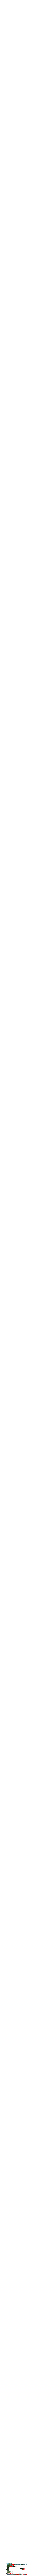

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.23
backpack 62.97
sandwich 61.6
microwave 60.46
book 60.12
bicycle 65.42
car 60.3
bus 60.21
bench 64.82
bear 64.63
backpack 66.16
handbag 61.63
suitcase 63.5
baseball bat 65.1
surfboard 66.63
spoon 65.22
sandwich 66.63
pizza 63.86
mouse 63.99
remote 64.55
keyboard 60.38
microwave 62.63
book 63.21
handbag 62.8
baseball bat 62.78
surfboard 63.74
cup 61.52
spoon 62.21
bicycle 65.05
car 62.04
bus 64.34
truck 60.54
bench 65.08
bear 62.71
backpack 65.8
handbag 61.78
suitcase 64.63
baseball bat 63.1
surfboard 65.95
spoon 63.48
sandwich 65.3
pizza 65.27
cake 60.57
mouse 62.59
remote 61.13
keyboard 64.69
microwave 60.78
book 64.27
bus 67.5
truck 61.78
traffic light 67.81
parking meter 67.9
bench 64.9
horse 63.45
elephant 65.29
backpack 67.95
tie 65.51
suitcase 65.3
skis 66.37
bowl 67.65
apple 67.22
sandwich 62.05
pottedplant 61.81
diningtable 61.98
toilet 67.67
tvmonitor 63.81
clock 64.52
teddy bear 63.36
toothbrush 68.37
bicycle 62

carrot 78.49
hot dog 79.53
chair 62.27
pottedplant 75.63
bed 80.22
diningtable 80.21
toilet 79.39
tvmonitor 82.13
cell phone 64.0
microwave 62.96
book 74.47
teddy bear 82.11
toothbrush 82.09
car 75.99
aeroplane 75.58
bus 73.77
traffic light 74.38
parking meter 76.14
bench 73.58
dog 71.88
sheep 72.83
cow 75.84
elephant 76.07
zebra 74.9
giraffe 68.51
backpack 76.02
handbag 60.5
tie 75.11
suitcase 76.13
skis 76.01
sports ball 73.98
kite 76.07
baseball bat 60.76
bottle 75.73
bowl 75.87
carrot 73.16
hot dog 74.58
pottedplant 70.79
bed 74.61
diningtable 74.71
toilet 73.92
tvmonitor 76.13
cell phone 60.32
book 65.95
teddy bear 76.12
toothbrush 76.1
car 81.77
aeroplane 78.02
bus 71.96
traffic light 81.79
parking meter 82.33
bench 80.88
dog 60.56
sheep 81.89
cow 80.82
elephant 80.53
bear 81.3
zebra 62.37
giraffe 76.91
backpack 81.42
tie 80.05
suitcase 82.32
skis 81.87
snowboard 75.49
sports ball 62.77
kite 81.3
bottle 81.28
bowl 81.81
carrot 78.89
hot dog 78.14
bed 79.39
toilet 78.26
tvmonitor 

toilet 74.76
tvmonitor 78.07
cell phone 60.69
book 71.26
teddy bear 78.06
toothbrush 78.05
car 76.64
aeroplane 76.36
bus 73.04
traffic light 73.62
parking meter 76.83
bench 74.8
dog 72.01
sheep 74.39
cow 76.56
elephant 76.75
zebra 75.5
giraffe 68.22
backpack 76.78
handbag 62.99
tie 76.14
suitcase 76.83
skis 76.75
snowboard 61.94
sports ball 75.58
kite 76.79
bottle 76.38
bowl 76.57
carrot 73.87
hot dog 74.48
pottedplant 70.18
bed 75.03
diningtable 75.33
toilet 73.62
tvmonitor 76.83
book 69.22
teddy bear 76.82
toothbrush 76.81
car 77.08
aeroplane 76.79
bus 73.25
traffic light 74.08
parking meter 77.3
bench 74.97
dog 72.0
sheep 74.75
cow 77.02
elephant 77.22
zebra 75.73
giraffe 67.31
backpack 77.24
handbag 62.53
tie 76.55
suitcase 77.3
skis 77.21
sports ball 75.98
kite 77.25
bottle 76.88
bowl 77.06
carrot 74.36
hot dog 75.13
pottedplant 70.63
bed 75.67
diningtable 75.98
toilet 73.75
tvmonitor 77.29
cell phone 61.54
book 70.23
teddy bear 77.28
toothbrush 77.27
car 73.4
aeroplane 73.17
bus 

carrot 62.66
donut 64.38
cake 63.87
tvmonitor 64.67
cell phone 65.46
sink 66.11
snowboard 60.02
toaster 62.82
clock 62.88
skateboard 62.45
carrot 60.34
donut 61.48
cake 61.27
tvmonitor 62.48
cell phone 63.22
sink 64.52
toaster 61.64
clock 61.67
dog 65.39
sheep 63.11
skateboard 68.04
carrot 67.2
donut 68.0
cake 66.08
tvmonitor 69.86
cell phone 68.98
sink 70.58
dog 60.43
skateboard 62.71
cup 60.64
carrot 61.04
donut 64.59
cake 60.23
tvmonitor 65.21
cell phone 63.16
sink 67.61
toaster 62.01
clock 62.39


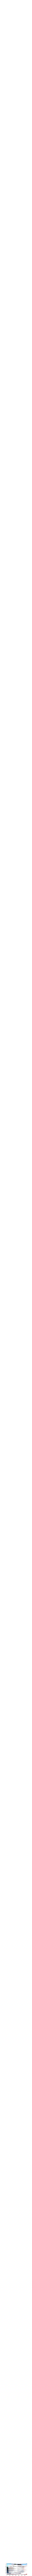

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 63.13
backpack 63.85
spoon 60.13
sandwich 62.4
microwave 61.46
book 61.02
bicycle 66.37
car 61.31
bus 61.81
bench 65.82
bear 65.67
backpack 67.24
handbag 62.69
suitcase 64.53
baseball bat 66.12
surfboard 67.65
spoon 66.26
sandwich 67.65
pizza 64.99
mouse 64.99
remote 65.64
keyboard 61.32
microwave 63.65
book 64.07
handbag 62.35
baseball bat 62.25
surfboard 63.3
cup 61.27
spoon 61.75
bicycle 65.55
car 62.6
bus 64.98
truck 60.58
bench 65.49
bear 63.45
backpack 66.24
handbag 62.34
suitcase 64.94
baseball bat 63.36
surfboard 66.39
spoon 64.01
sandwich 65.73
pizza 65.73
cake 61.07
mouse 63.22
remote 61.59
keyboard 65.01
microwave 61.02
book 64.78
bus 66.12
truck 60.55
traffic light 66.35
parking meter 66.51
bench 63.71
horse 62.09
elephant 64.17
backpack 66.45
tie 64.08
suitcase 64.05
skis 64.77
bowl 66.2
apple 65.75
sandwich 61.39
pottedplant 60.08
diningtable 60.81
toilet 66.16
tvmonitor 62.9
clock 62.92
teddy bear 61.78
toothbru

elephant 81.91
zebra 81.05
giraffe 74.19
backpack 81.93
handbag 65.93
tie 81.23
suitcase 82.0
skis 81.91
snowboard 67.55
sports ball 80.23
kite 81.93
baseball bat 63.95
bottle 81.55
bowl 81.77
carrot 78.41
hot dog 78.96
chair 64.16
pottedplant 75.72
bed 80.09
diningtable 80.08
toilet 79.36
tvmonitor 81.99
cell phone 66.53
microwave 61.75
book 72.96
teddy bear 81.98
toothbrush 81.97
car 82.68
aeroplane 82.21
bus 79.85
traffic light 80.04
parking meter 82.85
bench 80.11
dog 77.42
sheep 78.91
cow 82.48
elephant 82.74
zebra 81.7
giraffe 73.67
backpack 82.77
handbag 65.63
tie 81.98
suitcase 82.84
skis 82.75
snowboard 69.08
sports ball 81.38
kite 82.78
baseball bat 62.27
bottle 82.45
bowl 82.6
carrot 78.9
hot dog 79.95
chair 60.86
pottedplant 75.88
bed 81.17
diningtable 80.98
toilet 80.03
tvmonitor 82.84
cell phone 66.66
microwave 63.51
book 74.95
teddy bear 82.82
toothbrush 82.81
car 74.99
aeroplane 74.55
bus 73.21
traffic light 73.35
parking meter 75.11
bench 72.66
dog 70.15
sheep 71.64
co

parking meter 73.78
bench 71.47
dog 69.33
sheep 71.59
cow 73.5
elephant 73.69
zebra 72.48
giraffe 65.14
backpack 73.71
handbag 60.75
tie 73.07
suitcase 73.78
skis 73.71
sports ball 72.59
kite 73.74
bottle 73.42
bowl 73.53
carrot 70.7
hot dog 71.54
pottedplant 68.25
bed 72.03
diningtable 72.26
toilet 70.67
tvmonitor 73.78
book 66.98
teddy bear 73.77
toothbrush 73.76
car 77.21
aeroplane 76.9
bus 73.44
traffic light 74.07
parking meter 77.38
bench 75.15
dog 72.85
sheep 74.86
cow 77.1
elephant 77.29
zebra 75.83
giraffe 68.36
backpack 77.31
handbag 62.87
tie 76.6
suitcase 77.38
skis 77.3
sports ball 75.99
kite 77.34
bottle 76.98
bowl 77.11
carrot 74.24
hot dog 75.13
pottedplant 71.12
bed 75.75
diningtable 75.71
toilet 73.86
tvmonitor 77.38
cell phone 60.33
book 70.04
teddy bear 77.37
toothbrush 77.36
car 77.1
aeroplane 76.82
bus 73.09
traffic light 74.31
parking meter 77.28
bench 74.95
dog 72.55
sheep 74.85
cow 76.98
elephant 77.19
zebra 75.71
giraffe 68.24
backpack 77.22
handbag 63.01
tie 

cell phone 63.82
sink 64.14
skateboard 62.55
carrot 60.94
donut 62.81
cake 62.28
tvmonitor 63.03
cell phone 63.43
sink 63.73
skateboard 62.43
carrot 60.8
donut 62.66
cake 62.09
tvmonitor 62.87
cell phone 63.39
sink 63.66
clock 60.09
skateboard 62.32
carrot 60.75
donut 62.61
cake 61.99
tvmonitor 62.8
cell phone 63.21
sink 63.51
skateboard 62.24
carrot 60.73
donut 62.42
cake 61.83
tvmonitor 62.62
cell phone 63.19
sink 63.36
skateboard 62.41
carrot 60.84
donut 62.71
cake 62.13
tvmonitor 62.89
cell phone 63.42
sink 63.72
skateboard 62.32
carrot 60.72
donut 62.55
cake 61.94
tvmonitor 62.75
cell phone 63.26
sink 63.54
skateboard 62.35
carrot 60.9
donut 62.62
cake 61.98
tvmonitor 62.79
cell phone 63.26
sink 63.53
skateboard 63.23
carrot 61.61
donut 63.65
cake 63.0
tvmonitor 63.7
cell phone 64.13
sink 64.46
skateboard 62.55
carrot 60.98
donut 62.83
cake 62.16
tvmonitor 63.01
cell phone 63.45
sink 63.81
toaster 60.01
clock 60.07
skateboard 63.07
carrot 61.47
donut 63.38
cake 62.71
tvmonitor 63.

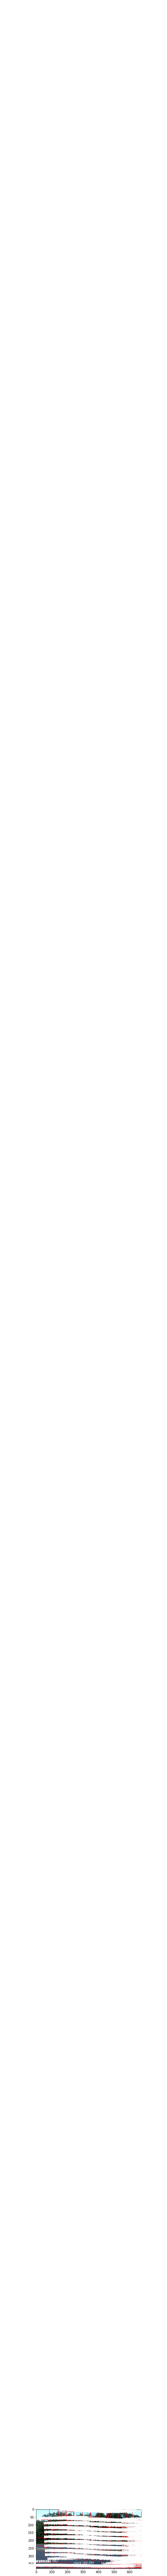

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 62.45
backpack 63.18
sandwich 61.81
microwave 60.62
book 60.41
bicycle 65.9
car 61.02
bus 60.91
bench 65.29
bear 65.13
backpack 66.7
handbag 62.13
suitcase 64.04
baseball bat 65.66
surfboard 67.16
spoon 65.81
sandwich 67.14
pizza 64.47
mouse 64.52
remote 65.15
keyboard 60.76
microwave 63.08
book 63.7
handbag 62.16
baseball bat 62.16
surfboard 63.08
cup 60.98
spoon 61.59
bicycle 65.38
car 62.21
bus 64.71
truck 60.45
bench 65.37
bear 63.16
backpack 66.11
handbag 62.07
suitcase 64.93
baseball bat 63.4
surfboard 66.25
spoon 63.8
sandwich 65.64
pizza 65.59
cake 60.8
mouse 63.01
remote 61.55
keyboard 64.96
microwave 60.95
book 64.5
bus 67.13
truck 61.94
traffic light 67.44
parking meter 67.64
bench 64.68
horse 63.45
elephant 65.29
backpack 67.59
tie 65.22
suitcase 64.88
skis 65.82
bowl 67.38
apple 66.71
sandwich 62.08
pottedplant 61.48
diningtable 61.34
toilet 67.34
tvmonitor 63.63
clock 63.98
teddy bear 62.94
toothbrush 68.02
bicyc

kite 82.43
baseball bat 63.06
bottle 82.14
bowl 82.27
carrot 79.51
hot dog 79.68
chair 65.63
pottedplant 76.17
bed 80.61
diningtable 80.66
toilet 79.99
tvmonitor 82.5
cell phone 65.1
microwave 60.78
book 75.16
teddy bear 82.49
toothbrush 82.48
person 62.15
car 83.85
aeroplane 83.47
bus 81.48
traffic light 81.24
parking meter 84.01
bench 81.5
dog 79.0
sheep 79.97
cow 83.68
elephant 83.92
zebra 82.9
giraffe 75.94
backpack 83.95
handbag 67.87
tie 83.21
suitcase 84.01
skis 83.93
snowboard 69.91
sports ball 82.55
kite 83.96
baseball bat 63.56
bottle 83.63
bowl 83.78
carrot 80.72
hot dog 81.5
chair 63.05
pottedplant 76.72
bed 81.99
diningtable 82.25
toilet 81.08
tvmonitor 84.01
cell phone 65.44
microwave 61.61
refrigerator 61.42
book 75.16
clock 62.57
teddy bear 84.0
toothbrush 83.99
person 61.16
car 76.63
aeroplane 76.24
bus 74.63
traffic light 75.0
parking meter 76.74
bench 74.22
dog 71.17
sheep 73.47
cow 76.46
elephant 76.68
zebra 75.57
giraffe 67.54
backpack 76.64
handbag 62.11
tie 75.87

parking meter 63.46
bench 62.67
sheep 60.31
cow 63.25
elephant 62.99
backpack 63.17
tie 61.72
suitcase 63.46
skis 63.33
kite 63.36
bottle 63.23
bowl 63.3
carrot 61.85
hot dog 61.62
toilet 62.11
tvmonitor 63.44
teddy bear 63.45
toothbrush 63.4
car 70.37
aeroplane 70.27
bus 69.18
traffic light 66.14
parking meter 70.6
bench 68.6
dog 65.89
sheep 67.23
cow 70.25
elephant 70.39
zebra 69.04
giraffe 64.02
backpack 70.46
tie 69.91
suitcase 70.6
skis 70.53
sports ball 68.82
kite 70.56
bottle 70.36
bowl 70.37
carrot 68.55
hot dog 68.42
pottedplant 64.63
bed 68.47
diningtable 68.11
toilet 67.47
tvmonitor 70.59
book 65.23
teddy bear 70.58
toothbrush 70.58
car 71.17
aeroplane 70.9
bus 68.79
traffic light 68.09
parking meter 71.36
bench 69.03
dog 65.84
sheep 68.71
cow 71.04
elephant 71.25
zebra 70.24
giraffe 64.29
backpack 71.28
tie 70.61
suitcase 71.36
skis 71.29
sports ball 70.24
kite 71.32
bottle 71.1
bowl 71.12
carrot 68.48
hot dog 69.06
pottedplant 65.95
bed 69.67
diningtable 69.57
toilet 67.88

sink 63.97
skateboard 63.19
carrot 61.31
donut 63.3
cake 62.72
tvmonitor 63.73
cell phone 64.1
sink 64.34
clock 60.16
skateboard 63.67
carrot 61.98
donut 63.92
cake 63.28
tvmonitor 64.11
cell phone 64.55
sink 64.89
toaster 60.33
clock 60.45
skateboard 63.17
carrot 61.42
donut 63.4
cake 62.83
tvmonitor 63.76
cell phone 64.04
sink 64.42
toaster 60.11
clock 60.18
skateboard 63.3
carrot 61.55
donut 63.63
cake 62.99
tvmonitor 63.87
cell phone 64.2
sink 64.57
toaster 60.09
clock 60.2
skateboard 62.51
carrot 61.18
donut 63.09
cake 62.44
tvmonitor 63.24
cell phone 63.6
sink 64.08
clock 60.01
skateboard 63.27
carrot 61.79
donut 63.69
cake 63.23
tvmonitor 64.14
cell phone 64.26
sink 64.62
skateboard 62.48
carrot 61.48
donut 63.19
cake 62.59
tvmonitor 63.35
cell phone 63.79
sink 64.28
skateboard 63.04
carrot 61.49
donut 63.42
cake 63.02
tvmonitor 63.91
cell phone 64.43
sink 65.23
toaster 61.55
clock 61.71
skateboard 62.04
donut 61.17
cake 61.11
tvmonitor 62.22
cell phone 62.8
sink 64.11
toaster 6

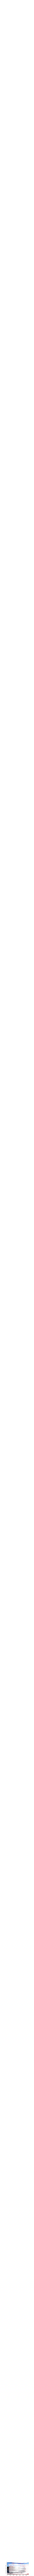

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.58
backpack 62.31
sandwich 60.91
microwave 60.09
bicycle 66.45
car 61.44
bus 61.64
bench 65.65
bear 65.57
backpack 67.05
handbag 62.81
suitcase 64.38
baseball bat 65.91
surfboard 67.56
spoon 66.14
sandwich 67.54
pizza 64.9
mouse 64.79
remote 65.51
keyboard 61.15
microwave 63.64
book 64.31
handbag 62.3
baseball bat 62.3
surfboard 63.12
cup 61.38
spoon 61.8
bicycle 65.56
car 62.87
bus 64.89
truck 60.91
bench 65.59
bear 63.37
backpack 66.27
handbag 62.34
suitcase 65.01
baseball bat 63.69
surfboard 66.4
spoon 64.22
sandwich 65.79
pizza 65.74
cake 60.89
mouse 63.13
remote 61.82
keyboard 65.16
microwave 61.25
book 64.84
bus 67.61
truck 61.93
traffic light 67.9
parking meter 68.11
bench 65.19
horse 63.86
elephant 65.66
backpack 68.04
tie 65.71
suitcase 65.37
skis 66.42
bowl 67.83
apple 67.16
sandwich 62.46
pottedplant 62.06
diningtable 61.52
toilet 67.83
tvmonitor 64.22
clock 64.48
teddy bear 63.13
toothbrush 68.47
bus 60.67
bench

microwave 61.84
book 73.58
clock 63.02
teddy bear 80.26
toothbrush 80.25
car 82.31
aeroplane 81.84
bus 80.22
traffic light 79.17
parking meter 82.47
bench 79.83
dog 77.74
sheep 78.42
cow 82.11
elephant 82.38
zebra 81.62
giraffe 74.07
backpack 82.42
handbag 67.8
tie 81.77
suitcase 82.47
skis 82.4
snowboard 66.62
sports ball 81.05
kite 82.41
baseball bat 62.94
bottle 81.98
bowl 82.22
carrot 78.64
hot dog 80.14
chair 63.2
pottedplant 77.12
bed 80.85
diningtable 80.37
toilet 80.02
tvmonitor 82.47
cell phone 64.13
microwave 62.81
book 73.83
clock 62.55
teddy bear 82.46
toothbrush 82.45
car 79.35
aeroplane 78.97
bus 77.15
traffic light 76.23
parking meter 79.49
bench 76.96
dog 75.23
sheep 76.05
cow 79.17
elephant 79.41
zebra 78.74
giraffe 70.66
backpack 79.43
handbag 64.98
tie 78.67
suitcase 79.49
skis 79.41
snowboard 64.93
sports ball 78.09
kite 79.43
baseball bat 61.18
bottle 79.07
bowl 79.25
carrot 76.16
hot dog 77.25
chair 62.01
pottedplant 73.72
bed 77.78
diningtable 77.76
toilet 77.17


skis 71.63
sports ball 70.1
kite 71.7
bottle 71.28
bowl 71.46
carrot 69.19
hot dog 69.98
pottedplant 66.94
bed 70.52
diningtable 70.77
toilet 68.86
tvmonitor 71.74
book 62.35
teddy bear 71.73
toothbrush 71.71
car 77.38
aeroplane 74.37
bus 67.96
traffic light 77.12
parking meter 77.86
bench 76.4
sheep 77.41
cow 76.43
elephant 76.2
bear 77.08
giraffe 73.01
backpack 76.81
tie 75.2
suitcase 77.85
skis 77.34
snowboard 71.8
kite 77.08
bottle 76.88
bowl 77.32
carrot 74.17
hot dog 73.7
bed 74.74
toilet 73.44
tvmonitor 77.38
remote 75.68
book 72.09
teddy bear 77.81
toothbrush 77.56
car 63.07
aeroplane 62.98
bus 61.36
traffic light 63.34
parking meter 63.64
bench 62.79
sheep 60.82
cow 63.43
elephant 63.12
backpack 63.36
tie 61.88
suitcase 63.64
skis 63.5
kite 63.53
bottle 63.4
bowl 63.48
carrot 61.82
hot dog 61.48
diningtable 60.34
toilet 61.96
tvmonitor 63.62
teddy bear 63.63
toothbrush 63.59
car 72.6
aeroplane 72.51
bus 71.41
traffic light 68.56
parking meter 72.86
bench 70.8
dog 67.76
sheep 6

carrot 62.03
donut 60.01
cell phone 61.56
sink 62.8
book 60.06
cup 60.48
tvmonitor 60.52
cell phone 60.87
sink 63.2
carrot 60.31
sink 61.07
tvmonitor 60.22
cell phone 60.76
sink 62.85
sink 60.23
cup 61.97
spoon 61.47
carrot 62.85
donut 60.93
cell phone 62.14
sink 63.52
book 60.17
snowboard 60.62
cup 61.91
tvmonitor 61.91
cell phone 62.16
sink 64.57
carrot 60.44
sink 60.64
cup 62.04
spoon 61.36
carrot 63.01
donut 60.66
cell phone 62.36
sink 63.72
book 60.89
cup 60.49
tvmonitor 60.44
cell phone 60.82
sink 63.07
carrot 60.91
cell phone 60.37
sink 61.14
car 60.08
cup 61.55
spoon 61.03
carrot 62.5
donut 60.11
cell phone 61.78
sink 63.23
book 60.21
snowboard 61.88
cup 62.03
tvmonitor 62.97
cell phone 62.92
sink 65.18
carrot 60.7
cell phone 60.05
sink 60.91
car 60.16
cup 61.78
spoon 61.36
carrot 62.87
donut 60.06
cell phone 62.12
sink 63.49
book 60.31
cup 61.42
tvmonitor 62.07
cell phone 62.21
sink 64.42
carrot 60.6
cell phone 60.01
sink 60.72
car 60.76
umbrella 60.91
snowboard 60.62
cup 63.4

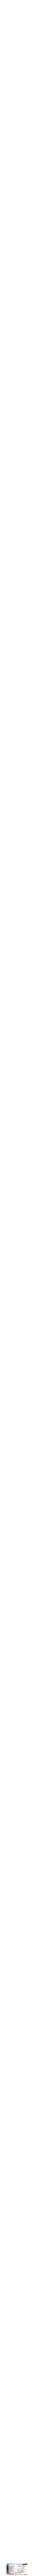

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 63.0
backpack 63.69
spoon 60.1
sandwich 62.24
microwave 61.36
book 60.91
bicycle 67.11
car 61.9
bus 61.83
bench 66.35
bear 66.24
backpack 67.83
handbag 63.01
tie 60.45
suitcase 65.29
baseball bat 66.7
surfboard 68.29
spoon 66.97
bowl 60.63
sandwich 68.29
pizza 65.47
mouse 65.68
remote 66.31
keyboard 61.55
microwave 64.54
book 64.89
handbag 63.28
baseball bat 63.26
surfboard 64.19
cup 62.09
spoon 62.84
keyboard 60.55
bicycle 66.46
car 63.46
bus 65.82
truck 61.41
bench 66.5
bear 64.16
backpack 67.14
handbag 63.3
suitcase 65.98
baseball bat 64.1
surfboard 67.29
spoon 64.83
sandwich 66.67
pizza 66.6
cake 62.09
mouse 64.07
remote 62.73
keyboard 66.01
microwave 62.09
book 65.49
bus 67.39
truck 61.95
traffic light 67.62
parking meter 67.71
bench 64.72
horse 63.26
elephant 65.63
backpack 67.72
tie 65.26
suitcase 65.02
skis 66.2
bowl 67.43
apple 67.04
sandwich 62.34
pottedplant 61.04
diningtable 61.94
toilet 67.42
tvmonitor 64.43
clock

toothbrush 80.53
car 80.31
aeroplane 79.84
bus 78.21
traffic light 77.16
parking meter 80.46
bench 77.96
dog 76.13
sheep 76.69
cow 80.02
elephant 80.4
zebra 79.71
giraffe 72.87
backpack 80.4
handbag 65.73
tie 79.64
suitcase 80.46
skis 80.38
snowboard 66.02
sports ball 78.92
kite 80.41
baseball bat 61.4
bottle 80.08
bowl 80.22
carrot 76.92
hot dog 78.17
chair 61.99
pottedplant 75.66
bed 78.97
diningtable 78.55
toilet 77.83
tvmonitor 80.46
cell phone 65.23
book 71.82
teddy bear 80.45
toothbrush 80.44
car 82.89
aeroplane 82.56
bus 79.96
traffic light 79.76
parking meter 83.07
bench 80.42
dog 78.7
sheep 79.56
cow 82.67
elephant 82.98
zebra 82.12
giraffe 74.4
backpack 83.01
handbag 66.63
tie 82.37
suitcase 83.07
skis 82.98
snowboard 70.02
sports ball 81.51
kite 83.01
baseball bat 67.32
bottle 82.58
bowl 82.86
carrot 79.4
hot dog 80.28
chair 65.52
pottedplant 77.12
bed 81.32
diningtable 81.22
toilet 80.54
tvmonitor 83.07
cell phone 63.08
microwave 63.72
book 72.74
clock 61.17
teddy bear 83.0

cow 71.17
elephant 71.36
zebra 69.56
giraffe 62.64
backpack 71.29
tie 70.45
suitcase 71.43
skis 71.32
sports ball 69.77
kite 71.39
bottle 71.02
bowl 71.13
carrot 68.52
hot dog 69.73
pottedplant 66.56
bed 70.28
diningtable 70.36
toilet 68.17
tvmonitor 71.42
book 62.56
teddy bear 71.41
toothbrush 71.39
car 77.07
aeroplane 74.06
bus 67.27
traffic light 76.85
parking meter 77.57
bench 76.01
sheep 77.16
cow 76.23
elephant 75.83
bear 76.8
giraffe 72.54
backpack 76.56
tie 74.96
suitcase 77.57
skis 77.06
snowboard 71.55
kite 76.88
bottle 76.51
bowl 77.01
carrot 74.08
hot dog 73.41
bed 74.41
toilet 73.31
tvmonitor 77.08
remote 75.27
book 72.0
teddy bear 77.53
toothbrush 77.26
car 65.44
aeroplane 65.45
bus 63.65
traffic light 65.68
parking meter 66.04
bench 65.11
dog 61.87
sheep 62.81
cow 65.83
elephant 65.56
backpack 65.78
tie 64.25
suitcase 66.04
skis 65.91
kite 65.94
bottle 65.79
bowl 65.87
carrot 64.37
hot dog 63.87
diningtable 62.98
toilet 64.45
tvmonitor 66.02
teddy bear 66.03
toothbrush 6

cell phone 60.38
sink 61.31
cup 61.77
spoon 61.19
carrot 62.82
donut 60.24
cell phone 62.12
sink 63.47
book 60.35
snowboard 60.19
cup 61.34
tvmonitor 61.67
cell phone 62.0
sink 64.23
carrot 61.15
cell phone 60.55
sink 61.27
cup 62.4
spoon 62.0
carrot 63.53
donut 61.31
cell phone 62.91
sink 64.1
book 61.27
cup 60.05
cell phone 60.5
sink 62.52
car 60.62
snowboard 60.9
spoon 61.45
carrot 62.43
cake 61.81
cell phone 62.3
sink 62.64
book 61.25
car 60.69
dog 60.04
spoon 61.12
carrot 62.64
cake 61.03
cell phone 61.97
sink 62.82
book 61.18
car 62.09
snowboard 60.66
cup 63.98
knife 61.34
spoon 64.2
carrot 65.2
donut 62.7
cake 61.19
tvmonitor 60.67
cell phone 64.74
sink 65.94
book 61.76
spoon 60.69
carrot 61.43
cake 61.05
cell phone 61.27
sink 61.58
car 62.12
knife 60.2
spoon 62.7
carrot 63.96
donut 62.09
cake 63.03
cell phone 63.71
sink 64.14
book 60.5
car 63.79
umbrella 62.29
snowboard 60.78
cup 64.88
knife 63.66
spoon 66.51
carrot 66.7
donut 65.06
cake 63.26
tvmonitor 62.8
cell phone 66.87
si

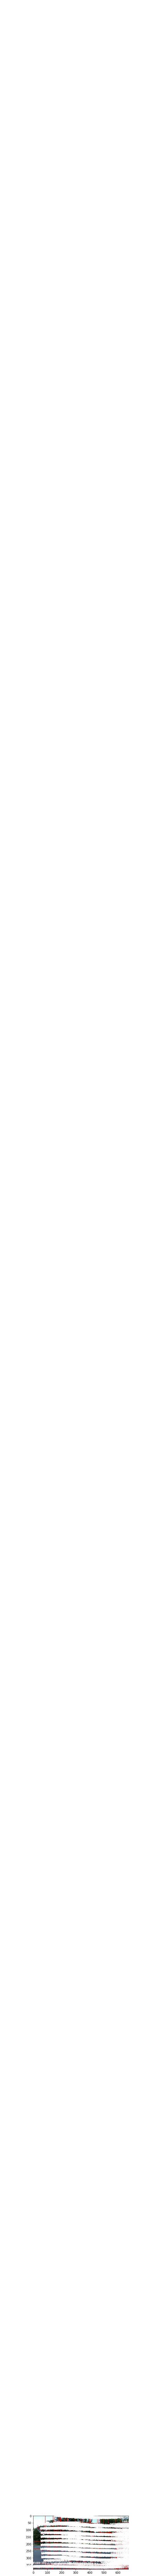

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
bear 61.66
backpack 62.37
sandwich 60.83
bicycle 66.36
car 60.86
bus 61.35
bench 65.8
bear 65.53
backpack 67.1
handbag 62.32
suitcase 64.61
baseball bat 65.99
surfboard 67.6
spoon 66.19
sandwich 67.59
pizza 64.92
mouse 64.96
remote 65.54
keyboard 60.79
microwave 63.51
book 63.91
handbag 61.44
baseball bat 61.37
surfboard 62.31
cup 60.19
spoon 60.75
bicycle 66.24
car 63.16
bus 65.65
truck 61.96
bench 66.3
bear 63.95
backpack 67.0
handbag 62.92
suitcase 65.76
baseball bat 64.2
surfboard 67.17
spoon 64.69
sandwich 66.5
pizza 66.45
cake 62.07
mouse 63.72
remote 62.26
keyboard 65.89
microwave 61.6
book 65.44
bus 67.17
truck 61.61
traffic light 67.37
parking meter 67.5
bench 64.47
horse 62.88
elephant 65.28
backpack 67.5
tie 64.92
suitcase 64.84
skis 65.73
bowl 67.23
apple 66.55
sandwich 61.73
pottedplant 61.67
diningtable 61.04
toilet 67.28
tvmonitor 63.92
clock 64.15
teddy bear 62.45
toothbrush 67.96
bus 60.44
bench 60.74
backpack 61.0

bottle 82.52
bowl 82.68
carrot 79.41
hot dog 80.74
chair 62.55
pottedplant 76.51
bed 81.19
diningtable 81.31
toilet 80.21
tvmonitor 82.94
cell phone 65.53
microwave 62.63
refrigerator 60.83
book 75.83
clock 61.4
teddy bear 82.92
toothbrush 82.91
car 72.2
aeroplane 71.84
bus 70.1
traffic light 70.82
parking meter 72.32
bench 69.85
dog 67.67
sheep 69.41
cow 72.04
elephant 72.25
zebra 71.26
giraffe 64.41
backpack 72.22
tie 71.36
suitcase 72.32
skis 72.2
sports ball 70.5
kite 72.28
bottle 71.94
bowl 72.11
carrot 69.35
hot dog 70.63
pottedplant 67.01
bed 71.21
diningtable 71.01
toilet 70.38
tvmonitor 72.32
book 64.21
teddy bear 72.3
toothbrush 72.29
car 79.4
aeroplane 75.47
bus 70.48
traffic light 79.37
parking meter 79.99
bench 78.49
sheep 79.5
cow 78.59
elephant 78.11
bear 79.04
zebra 61.39
giraffe 74.75
backpack 79.13
tie 78.01
suitcase 79.98
skis 79.53
snowboard 73.55
sports ball 61.67
kite 79.07
bottle 78.86
bowl 79.55
carrot 76.45
hot dog 75.49
bed 76.53
toilet 76.34
tvmonitor 79.5
re

bed 72.43
diningtable 72.27
toilet 70.52
tvmonitor 74.07
book 68.65
teddy bear 74.06
toothbrush 74.05
car 72.51
aeroplane 72.27
bus 69.79
traffic light 69.72
parking meter 72.7
bench 70.73
dog 68.23
sheep 70.3
cow 72.38
elephant 72.62
zebra 71.49
giraffe 65.53
backpack 72.64
handbag 60.14
tie 71.96
suitcase 72.7
skis 72.63
sports ball 71.44
kite 72.66
bottle 72.33
bowl 72.46
carrot 69.73
hot dog 70.33
pottedplant 67.57
bed 71.15
diningtable 71.13
toilet 69.62
tvmonitor 72.7
book 65.62
teddy bear 72.69
toothbrush 72.68
car 75.41
aeroplane 75.19
bus 71.71
traffic light 72.47
parking meter 75.61
bench 73.27
dog 70.78
sheep 73.39
cow 75.28
elephant 75.52
zebra 74.14
giraffe 66.73
backpack 75.55
handbag 61.04
tie 74.89
suitcase 75.61
skis 75.53
sports ball 74.19
kite 75.57
bottle 75.17
bowl 75.39
carrot 72.46
hot dog 73.56
pottedplant 69.63
bed 74.04
diningtable 74.13
toilet 72.03
tvmonitor 75.61
book 68.91
teddy bear 75.6
toothbrush 75.59
car 77.19
aeroplane 76.92
bus 73.7
traffic light 74

sink 67.12
book 62.88
car 60.02
spoon 60.66
carrot 61.29
cake 61.05
cell phone 61.12
sink 61.36
car 60.87
spoon 61.42
carrot 62.43
donut 60.83
cake 61.52
cell phone 62.1
sink 62.62
car 64.97
dog 60.5
umbrella 62.73
snowboard 61.77
cup 65.8
knife 64.77
spoon 67.58
carrot 67.87
donut 66.15
cake 64.2
tvmonitor 63.92
cell phone 68.02
sink 68.83
book 61.02
cell phone 61.17
sink 62.9
carrot 60.08
carrot 60.54
cake 60.18
cell phone 60.3
carrot 60.3
cell phone 60.09
carrot 60.64
cake 60.24
cell phone 60.44
carrot 60.61
cake 60.29
cell phone 60.37
carrot 60.82
donut 60.02
cake 60.35
cell phone 60.61
carrot 60.76
cake 60.07
cell phone 60.46
car 61.67
umbrella 61.18
cup 63.07
knife 62.3
spoon 61.73
carrot 65.55
donut 63.44
cake 64.54
cell phone 65.41
sink 64.46
book 61.9
knife 61.42
carrot 63.65
donut 60.74
cake 62.36
cell phone 62.92
sink 62.19
umbrella 64.12
cup 65.79
knife 64.73
spoon 64.02
carrot 65.46
donut 63.29
cake 62.36
tvmonitor 62.04
cell phone 65.37
sink 65.04
skateboard 64.03
carrot 

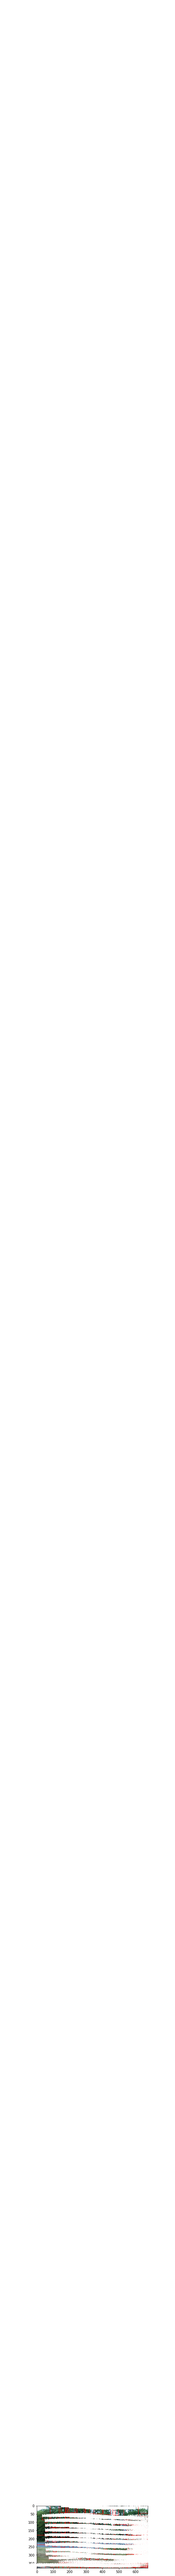

In [20]:
j=0
for i in range(len(glob.glob('/home/zahid/Downloads/objectDetection ssd/data/training_images/*.jpg'))):
    if j<=10:
        predict_bb_image(glob.glob('/home/zahid/Downloads/objectDetection ssd/data/training_images/*.jpg')[i])
        j+=1
    else:
        break